# Belief in Supernatural Evil and Guns
This is the second assignment for the course "Applied Machine Learning".

>Nikolas Moatsos <br />
>Department of Management Science and Technology <br />
>Athens University of Economics and Business

This assignment will replicate a study of belief in supernatural evil and attitudes towards guns in the United States. The study is:

Christopher G. Ellison, Benjamin Dowd-Arrow, Amy M. Burdette, Pablo E. Gonzalez, Margaret S. Kelley, Paul Froese,
"Peace through superior firepower: Belief in supernatural evil and attitudes toward gun policy in the United States", Social Science Research, Volume 99, 2021, https://doi.org/10.1016/j.ssresearch.2021.102595.

The study tries to link the belief in supernatural evil with a range of gun policy attitudes, by testing theoretical arguments regarding this linkage.

## Data Preparation

The dataset that will be used in this assignment are the responses from the *Wave Four of the Baylor Religion Survey* (BRS), which was conducted in January of 
2014\. This survey took a random sample of 1572 non-institutionalized respondents with ages from 18 and over, who reside in the continental United States. 

The responses were collected using a mixed model with phone interviews, mails and self-administered questionnaires. Moreover, the BRS survey includes a wide range of questions regarding attitudes towards gun control and gun policy issues, as well as relevant religious measures, information on political views and socio-demographic characteristics, which are very useful for the current study. 

The dataset is stored in *The Association of Religion Data Archives* (the ARDA) and can be found [here](https://www.thearda.com/Archive/Files/Descriptions/BRS2014.asp).

* Before we begin, we import all the necessary libraries that will be used throughout the assignment.

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import miceforest as mf

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import matplotlib.pyplot as plt

%matplotlib inline

* First, we download the dataset from the link above, we transform it from excel to csv and we create a DataFrame.

In [2]:
brs_data_all = pd.read_csv('data/Baylor_ Religion_Survey_Wave_IV_2014.csv')
brs_data_all

,MOTHERLODE_ID,PROJECT_ID,RESPONDENT_ID,METHOD_ID,METHOD_TYPE,PROJECT_NUMBER,CREATED_ON,PRACTICE,RESPONDENT_DATE,RESPONDENT_LANGUAGE,...,STATE,PROJWT,WEIGHT,Q2,RELTRAD,I_GENDER,I_EDUC,I_MARITAL,I_RELIGION,I_ATTEND
0,128170892,33370,01_000001_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,TX,20086.69661,0.270000,Church of Christ,1.0,2.0,5.0,3.0,1.0,6.0
1,128170893,33370,01_000002_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,TX,26218.57317,0.352423,Church of God In Christ,3.0,2.0,3.0,3.0,3.0,2.0
2,128170894,33370,01_000003_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,ND,41408.88989,0.556608,ELCA,2.0,2.0,3.0,1.0,2.0,6.0
3,128170895,33370,01_000004_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,TX,50023.02736,0.672397,Independent Methodist,2.0,2.0,4.0,3.0,2.0,5.0
4,128170896,33370,01_000005_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,IA,230734.42840,3.101474,Don't have specific name,1.0,1.0,2.0,2.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,128172920,33371,02_000301_00000013,162048140_02,SCAN,162048140,3/26/2014,OTHER,3/10/2014,es-AR,...,CA,17054.91266,0.229248,NaN,4.0,2.0,5.0,2.0,4.0,2.0
1568,128172921,33371,02_000326_00000014,162048140_02,SCAN,162048140,3/26/2014,OTHER,3/12/2014,es-AR,...,CA,104454.33680,1.404049,NaN,4.0,2.0,2.0,2.0,4.0,1.0
1569,128172922,33371,02_000351_00000015,162048140_02,SCAN,162048140,3/26/2014,OTHER,3/19/2014,es-AR,...,CA,153453.64200,2.062685,NaN,6.0,2.0,3.0,1.0,5.0,6.0
1570,128172335,33371,02_000352_00000015,162048140_02,SCAN,162048140,3/26/2014,OTHER,3/19/2014,es-AR,...,CT,33324.20001,0.447935,Catolica Romana - Latinos,4.0,1.0,5.0,2.0,4.0,3.0


* The analysis, in the study, uses only a part of the survey, so we create a dictionary with all the questions that we need.

In [3]:
variables_dict = {
    'Ban_on_Semi_Auto_Guns': 'Q73A',
    'Ban_on_High_Capacity_Ammo_Clips': 'Q73E',
    'Banning_Civilian_Handguns': 'Q73G',
    'Support_for_Concealed_Carry_Laws': 'Q73H',
    'More_Armed_Security_at_Schools': 'Q73C',
    'More_Teachers_Faculty_having_Guns': 'Q73F',
    'More_Gun_Safety_Programs': 'Q73B',
    'Expanded_Mental_Health_Screening': 'Q73D',
    'Attendance': 'Q4',
    'Bible': 'Q17',
    'Religious_Affiliation': 'I_RELIGION',
    'Political_Ideology': 'Q31',
    'Age': 'AGE',
    'Sex': 'Q77',
    'White': 'Q88A',
    'African_American_Black': 'Q88B',
    'Hispanic': 'Q89',
    'American_Indian_or_Alaska_Native': 'Q88C',
    'Asian': 'Q88D',
    'Native_Hawaiian_or_other_Pacific_Islander': 'Q88E',
    'Other_Race': 'Q88F',
    'Education': 'I_EDUC',
    'Household_Income': 'Q95',
    'Marital_Status': 'I_MARITAL',
    'Children': 'Q93',
    'Children_None': 'Q93_NONE',
    'Children_General': 'Q55',
    'Area_Demographics': 'Q80',
    'Region': 'STATE',
    'Devil': 'Q23A', 
    'Hell': 'Q23C', 
    'Demons': 'Q23G'
    }

len(variables_dict)

32

* Next, we create a copy of our original dataset with only the needed variables. 
* We also adapt their names to be more understandable.

In [4]:
brs_data = brs_data_all[variables_dict.values()].copy()
brs_data.columns = variables_dict.keys()
brs_data

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Bible,...,Household_Income,Marital_Status,Children,Children_None,Children_General,Area_Demographics,Region,Devil,Hell,Demons
0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,2.0,3.0,NaN,1.0,1.0,4.0,TX,4.0,4.0,4.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,1.0,3.0,2.0,NaN,1.0,1.0,TX,4.0,4.0,4.0
2,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,7.0,2.0,...,3.0,1.0,NaN,NaN,2.0,3.0,ND,3.0,2.0,2.0
3,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,6.0,2.0,...,2.0,3.0,NaN,NaN,2.0,2.0,TX,4.0,4.0,4.0
4,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,8.0,1.0,...,5.0,2.0,2.0,NaN,1.0,1.0,IA,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,NaN,1.0,NaN,2.0,1.0,NaN,NaN,1.0,1.0,1.0,...,5.0,2.0,NaN,1.0,1.0,3.0,CA,4.0,2.0,4.0
1568,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,2.0,...,4.0,2.0,1.0,NaN,1.0,1.0,CA,3.0,3.0,3.0
1569,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,7.0,2.0,...,2.0,1.0,NaN,NaN,2.0,3.0,CA,4.0,4.0,3.0
1570,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,3.0,2.0,...,5.0,2.0,0.0,1.0,2.0,1.0,CT,3.0,3.0,3.0


* Now we have only the questions in which we are interested in. However, their not in the correct format for the analysis to proceed.
* As a result we have to prepare them and impute them, in order to be the same as those in the study.

### Dependent Variables

The dependent variables are : 
1. *Ban on Semi-Auto Guns*
2. *Ban on High-Capacity Ammo Clips*, 
3. *Banning Civilian Handguns* 
4. *Support for Concealed Carry Laws*, 
5. *More Armed Security at Schools*
6. *More Teachers/Faculty having Guns* 
7. *More Gun Safety Programs*
8. *Expanded Mental Health Screening*

* All the dependent variables (gun policies) are located in the first 8 columns of the dataset.
* The answers are 1 for "Favor", 2 for "Oppose" and NaN for the missing values.

In [5]:
brs_data.iloc[:,0].unique()

array([ 2., nan,  1.])

* In the study, the values are 1 and 0, so we tranform them accordingly.

In [6]:
for i in range(0,8):
    brs_data.iloc[:,i] = brs_data.iloc[:,i].apply(lambda x: 0 if x == 2 else x)

brs_data.head()

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Bible,...,Household_Income,Marital_Status,Children,Children_None,Children_General,Area_Demographics,Region,Devil,Hell,Demons
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,2.0,3.0,NaN,1.0,1.0,4.0,TX,4.0,4.0,4.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,1.0,3.0,2.0,NaN,1.0,1.0,TX,4.0,4.0,4.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,2.0,...,3.0,1.0,NaN,NaN,2.0,3.0,ND,3.0,2.0,2.0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,6.0,2.0,...,2.0,3.0,NaN,NaN,2.0,2.0,TX,4.0,4.0,4.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,1.0,...,5.0,2.0,2.0,NaN,1.0,1.0,IA,4.0,4.0,4.0


### Independent Variables

The independent variables are:
1. *Attendance*
2. *Bible (Human Error, History and Fables)*
3. *Biblical Inerrancy*
4. *Biblical Literalism*
5. *Conservative Protestant*
6. *Mainline Protestant*
7. *Black Protestant*
8. *Catholic*
9. *Other Religion*
10. *No Affiliation*
11. *Political Ideology*
12. *Age*
13. *Female*
14. *Male*
15. *White*
16. *Hispanic*
17. *African American/Black*
18. *Other Race*
19. *Less Than High School*
20. *High School or Equivalent*
21. *Some College*
22. *College Degree*
23. *Post-graduate Degree*
24. *Household Income*
25. *Not Partnered/Single*
26. *Married/Cohabitating*
27. *No kids under 18 in home*
28. *Kids under 18 in home*
29. *Small Town/Rural*
30. *Urban Area*
31. *South*
32. *Other Region*

* Some of the independent variables, in the DataFrame, are not in the correct format and have different issues that need to be addressed. So we take the appropriate action on each one separately.

#### Bible

* "Bible" refers to the statement that is closer to the responders belief about the bible.
* The answers are 1 for "Literalism", 2 for "Inerrancy", 3 for "Contains Human Error", 4 for "A book of history and legends" and 8 for "I don't know".

In [7]:
brs_data['Bible'].unique()

array([ 1.,  2.,  4.,  8.,  3., nan])

* We merge the last 3 categories into one (Human Error, History and Fables), similar to the study.

In [8]:
brs_data['Bible'] = brs_data['Bible'].apply(lambda x: 3 if x in [4,8] else x)
brs_data['Bible']

0       1.0
1       1.0
2       2.0
3       2.0
4       1.0
       ... 
1567    1.0
1568    2.0
1569    2.0
1570    2.0
1571    NaN
Name: Bible, Length: 1572, dtype: float64

#### Age

* The "Αge" despite the NaN values, has also some invalid values presented with 0.

In [9]:
brs_data['Age'].unique()

array([85,  0, 67, 64, 54, 29, 70, 57, 66, 27, 33, 73, 62, 71, 63, 65, 74,
       39, 44, 28, 56, 86, 24, 82, 26, 52, 42, 61, 32, 53, 77, 68, 69, 22,
       59, 72, 79, 40, 87, 58, 46, 35, 50, 51, 36, 31, 48, 25, 43, 45, 49,
       41, 38, 75, 37, 55, 84, 92, 23, 60, 80, 76, 78, 47, 30, 88, 90, 34,
       91, 83, 21, 93, 20, 81, 96, 95, 99, 89, 19, 94], dtype=int64)

* As a result, we transform them to NaN.

In [10]:
brs_data['Age'] = brs_data['Age'].apply(lambda x: np.nan if x == 0 else x)
brs_data['Age']

0       85.0
1        NaN
2       67.0
3       64.0
4       54.0
        ... 
1567    48.0
1568    59.0
1569    29.0
1570    57.0
1571     NaN
Name: Age, Length: 1572, dtype: float64

#### Sex

* "Sex" represents the gender, and the answers are 1 for "Male" and 2 for "Female".

In [11]:
brs_data['Sex'].unique()

array([ 2.,  1., nan])

* We transform the values to 1 and 0, since all the binary values in the study are in this format.

In [12]:
brs_data['Sex'] = brs_data['Sex'].apply(lambda x: 0 if x == 2 else x)
brs_data['Sex']

0       0.0
1       0.0
2       0.0
3       0.0
4       1.0
       ... 
1567    0.0
1568    0.0
1569    0.0
1570    1.0
1571    0.0
Name: Sex, Length: 1572, dtype: float64

#### Race

* The study categorizes the asnwers to 4 races: "White", "African American/Black", "Hispanic" and "Other Race".
* First, we merge all the other races.

In [13]:
def recode_other_race(o):
    if (o['American_Indian_or_Alaska_Native'] == 1) or (o['Asian'] == 1) or (o['Native_Hawaiian_or_other_Pacific_Islander'] == 1) or (o['Other_Race'] == 1):
        return 1
    else:
        return o['Other_Race']

other_races = ['American_Indian_or_Alaska_Native', 'Asian', 'Native_Hawaiian_or_other_Pacific_Islander', 'Other_Race']   
brs_data['Other_Race'] = brs_data[other_races].apply(recode_other_race, axis=1)
brs_data['Other_Race']

0       NaN
1       NaN
2       2.0
3       2.0
4       2.0
       ... 
1567    NaN
1568    NaN
1569    2.0
1570    NaN
1571    1.0
Name: Other_Race, Length: 1572, dtype: float64

* The "Hispanic" question has valid answers 2 to 8, so we transform the proper values to 1 and 0. 
* Also, transform the values of "White", "African American/Black" and "Other Race" to 1 and 0.  

In [14]:
def recode_hispanic(h):
    if h in range(2,9):
        return 1
    elif h == 1:
        return 0
    else:
        return h

brs_data['Hispanic'] = brs_data['Hispanic'].apply(recode_hispanic)

races = ['White', 'African_American_Black', 'Other_Race']
for race in races:
    brs_data[race] = brs_data[race].apply(lambda x: 0 if x == 2 else x)

races.append('Hispanic')
brs_data[races]

,White,African_American_Black,Other_Race,Hispanic
0,NaN,NaN,NaN,0.0
1,0.0,1.0,NaN,NaN
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,NaN
4,1.0,0.0,0.0,NaN
...,...,...,...,...
1567,NaN,NaN,NaN,1.0
1568,NaN,NaN,NaN,1.0
1569,0.0,0.0,0.0,1.0
1570,NaN,NaN,NaN,1.0


* Next, we check if there are discrepancies in the values.
* If there are not (sum of races = 1), we choose the race.
* In the other case, we check if the responder has answered "Hispanic"  and we set the race with this value, because we make the assumption that a repsonder could be Hispanic Black, Hispanic White or Hispanic with an other race.
* Otherwise, we return NaN. 

In [15]:
def recode_race(race):
    if race.sum() == 1:
        return race.idxmax()
    elif race.Hispanic == 1:
        return 'Hispanic'
    else: 
        return np.nan

brs_data['Race'] = brs_data[races].apply(recode_race, axis=1)
brs_data['Race']

0                          NaN
1       African_American_Black
2                        White
3                        White
4                        White
                 ...          
1567                  Hispanic
1568                  Hispanic
1569                  Hispanic
1570                  Hispanic
1571                  Hispanic
Name: Race, Length: 1572, dtype: object

* Lastly, we map the races with numbers.

In [16]:
map_races = {'White': 0, 'African_American_Black': 1, 'Other_Race': 2, 'Hispanic': 3}
brs_data['Race'] = brs_data['Race'].replace(map_races)
brs_data.drop(columns=races, inplace=True)
brs_data.drop(columns=other_races[:-1], inplace=True)
brs_data['Race']

0       NaN
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
1567    3.0
1568    3.0
1569    3.0
1570    3.0
1571    3.0
Name: Race, Length: 1572, dtype: float64

#### Education

* "Education" represents the level of education and has the answers: 1 for "Less than high school", 2 for "High School graduate", 3 for "Some College", 4 for "Technical Training", 5 for "College Graduate" and 6 for "Postgraduate Degree".

In [17]:
brs_data['Education'].unique()

array([ 5.,  3.,  4.,  2.,  6.,  1., nan])

* Similar to the study, we merge the answers "Some College" and "Technincal Training" into one.

In [18]:
brs_data['Education'] = brs_data['Education'].apply(lambda x: 3 if x == 4 else x)
brs_data['Education']

0       5.0
1       3.0
2       3.0
3       3.0
4       2.0
       ... 
1567    5.0
1568    2.0
1569    3.0
1570    5.0
1571    1.0
Name: Education, Length: 1572, dtype: float64

#### Marital Status

* "Marital Status" has the answers: 1 for "Single/never married", 2 for "Married or living as married/partnered", 3 for "Separated or divorced" and 4 for "Widowed".

In [19]:
brs_data['Marital_Status'].unique()

array([ 3.,  1.,  2.,  4., nan])

* We transform them to two answers "Not Partnered/Single" ("Single/never married", "Separated or divorced", " Widowed")  and "Married/Cohabitating".
* Also, we make the format to be binary with values 1 and 0.

In [20]:
def recode_married(m):
    if m == 2:
        return 1
    elif m in [1,3,4]:
        return 0
    else:
        return m

brs_data['Marital_Status'] = brs_data['Marital_Status'].apply(recode_married)
brs_data['Marital_Status']

0       0.0
1       0.0
2       0.0
3       0.0
4       1.0
       ... 
1567    1.0
1568    1.0
1569    0.0
1570    1.0
1571    NaN
Name: Marital_Status, Length: 1572, dtype: float64

#### Children Under 18

* "Children" must represent if a responder has children under 18 in the household.
* We check the question "Children" that has the number of the children under 18 in the household and if it's bigger than zero we transform it to 1.
* Next, we check the questions "Children_None" and "Children_General" to cross check the "Children" values.
* "Children_None" represents no children under 18 in the household, so if it has value 1("None") we fill "Children" with 0.
* "Children_General" represents if the responder has children in general, so if it has value 2 ("No") we fill "Children" with 0.
* Lastly, we check if there is discrepancy between the variables and in this case we set NaN.

In [21]:
def fill_none_children(c):
    if (c['Children_None'] == 1 or c['Children_General'] == 2) and c['Children'] == 1:
        return np.nan
    elif c['Children_None'] == 1 or c['Children_General'] == 2:
        return 0
    else:
        return c['Children']

brs_data['Children'] = brs_data['Children'].apply(lambda x: 1 if x > 0 else x)
brs_data['Children'] = brs_data[['Children', 'Children_None', 'Children_General']].apply(fill_none_children, axis=1)
brs_data.drop(columns=['Children_None', 'Children_General'], inplace=True)
brs_data['Children']

0       0.0
1       1.0
2       0.0
3       0.0
4       1.0
       ... 
1567    0.0
1568    1.0
1569    0.0
1570    0.0
1571    0.0
Name: Children, Length: 1572, dtype: float64

#### Area Demographics

* "Area Demographics" represents the area that the responder lives in and has the answers: 1 for "A large city", 2 for "A suburb near a large city", 3 for "A small city or town", 4 for "A rural area" and 8 for "Don't Know".

In [22]:
brs_data['Area_Demographics'].unique()

array([ 4.,  1.,  3.,  2., nan,  8.])

* Similar two the study we merge them into two answers "Small Town/Rural" and "Urban Area" and we transform the "Don't Know" values to NaN.

In [23]:
def recode_area(a):
    if a in [1,2]:
        return 0
    elif a in [3,4]:
        return 1
    else:
        return np.nan

brs_data['Area_Demographics'] = brs_data['Area_Demographics'].apply(recode_area)
brs_data['Area_Demographics']

0       1.0
1       0.0
2       1.0
3       0.0
4       0.0
       ... 
1567    1.0
1568    0.0
1569    1.0
1570    0.0
1571    0.0
Name: Area_Demographics, Length: 1572, dtype: float64

#### Region

* "Region" represents the south US states and the other US states.
* We create a list with the codes of the south states and we transform the values to 1 for the south (wherever the code is inside this list) and to 0 for the non-south.

In [24]:
south_states = ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV', 'DC']
brs_data['Region'] = brs_data['Region'].apply(lambda x: 1 if x in south_states else 0)
brs_data['Region']

0       1
1       1
2       0
3       1
4       0
       ..
1567    0
1568    0
1569    0
1570    0
1571    1
Name: Region, Length: 1572, dtype: int64

* Now, we have made the necessary cleansing and preparation of the data and we are ready to proceed with the imputation of the missing values.

In [25]:
brs_data.columns

Index(['Ban_on_Semi_Auto_Guns', 'Ban_on_High_Capacity_Ammo_Clips',
       'Banning_Civilian_Handguns', 'Support_for_Concealed_Carry_Laws',
       'More_Armed_Security_at_Schools', 'More_Teachers_Faculty_having_Guns',
       'More_Gun_Safety_Programs', 'Expanded_Mental_Health_Screening',
       'Attendance', 'Bible', 'Religious_Affiliation', 'Political_Ideology',
       'Age', 'Sex', 'Education', 'Household_Income', 'Marital_Status',
       'Children', 'Area_Demographics', 'Region', 'Devil', 'Hell', 'Demons',
       'Race'],
      dtype='object')

### Data Imputation

* We can see that in the DataFrame there are some missing values.

In [26]:
brs_data.isna().sum()

Ban_on_Semi_Auto_Guns                 70
Ban_on_High_Capacity_Ammo_Clips       70
Banning_Civilian_Handguns             71
Support_for_Concealed_Carry_Laws      70
More_Armed_Security_at_Schools        62
More_Teachers_Faculty_having_Guns     68
More_Gun_Safety_Programs              57
Expanded_Mental_Health_Screening      60
Attendance                            16
Bible                                 23
Religious_Affiliation                 91
Political_Ideology                    51
Age                                  104
Sex                                   36
Education                             71
Household_Income                     105
Marital_Status                        18
Children                              75
Area_Demographics                     52
Region                                 0
Devil                                 68
Hell                                  73
Demons                                80
Race                                 113
dtype: int64

In the study this issue is addressed via **multiple imputation**. In our case since we cannot operate a fully multiple imputation (create several different plausible imputed data sets and appropriately combining results obtained from each of them), we create only one imputed dataset and we use it for the analysis. To perform the imputation we use a python library named `miceforest` *(Version 5.2.0)*, which uses ligthgbm random forests to perform the MICE algorithm.

*More Information: https://github.com/AnotherSamWilson/miceforest*

* We run the MICE algorithm for 1 imputed dataset and for 3 iterations (to converge).

In [27]:
kernel = mf.ImputationKernel(
  brs_data,
  datasets=1,
  save_all_iterations=True,
  random_state=0
)

kernel.mice(3)

* We complete the dataset with the imputed data.

In [28]:
brs_data_imputed = kernel.complete_data(dataset=0, inplace=False)
brs_data_imputed.head()

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Bible,...,Education,Household_Income,Marital_Status,Children,Area_Demographics,Region,Devil,Hell,Demons,Race
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,5.0,2.0,0.0,0.0,1.0,1,4.0,4.0,4.0,0.0
1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,1.0,0.0,1.0,0.0,1,4.0,4.0,4.0,1.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,2.0,...,3.0,3.0,0.0,0.0,1.0,0,3.0,2.0,2.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,6.0,2.0,...,3.0,2.0,0.0,0.0,0.0,1,4.0,4.0,4.0,0.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,1.0,...,2.0,5.0,1.0,1.0,0.0,0,4.0,4.0,4.0,0.0


* We can see now that there are no more missing values.

In [29]:
brs_data_imputed.isnull().sum(0)

Ban_on_Semi_Auto_Guns                0
Ban_on_High_Capacity_Ammo_Clips      0
Banning_Civilian_Handguns            0
Support_for_Concealed_Carry_Laws     0
More_Armed_Security_at_Schools       0
More_Teachers_Faculty_having_Guns    0
More_Gun_Safety_Programs             0
Expanded_Mental_Health_Screening     0
Attendance                           0
Bible                                0
Religious_Affiliation                0
Political_Ideology                   0
Age                                  0
Sex                                  0
Education                            0
Household_Income                     0
Marital_Status                       0
Children                             0
Area_Demographics                    0
Region                               0
Devil                                0
Hell                                 0
Demons                               0
Race                                 0
dtype: int64

* We also see that the means of the variables have changed insignificantly.

In [30]:
abs(brs_data.mean() - brs_data_imputed.mean()).describe()

count    24.000000
mean      0.006066
std       0.009948
min       0.000000
25%       0.001120
50%       0.001850
75%       0.004785
max       0.035566
dtype: float64

* Lastly, through the `miceforest` librabry we can see how the imputed values are distributed. We can plot the original distribution (red) beside the imputed distribution (black).
* We notice that despite the small number of missing values, the distribution of the imputed data looks very similar with the original.

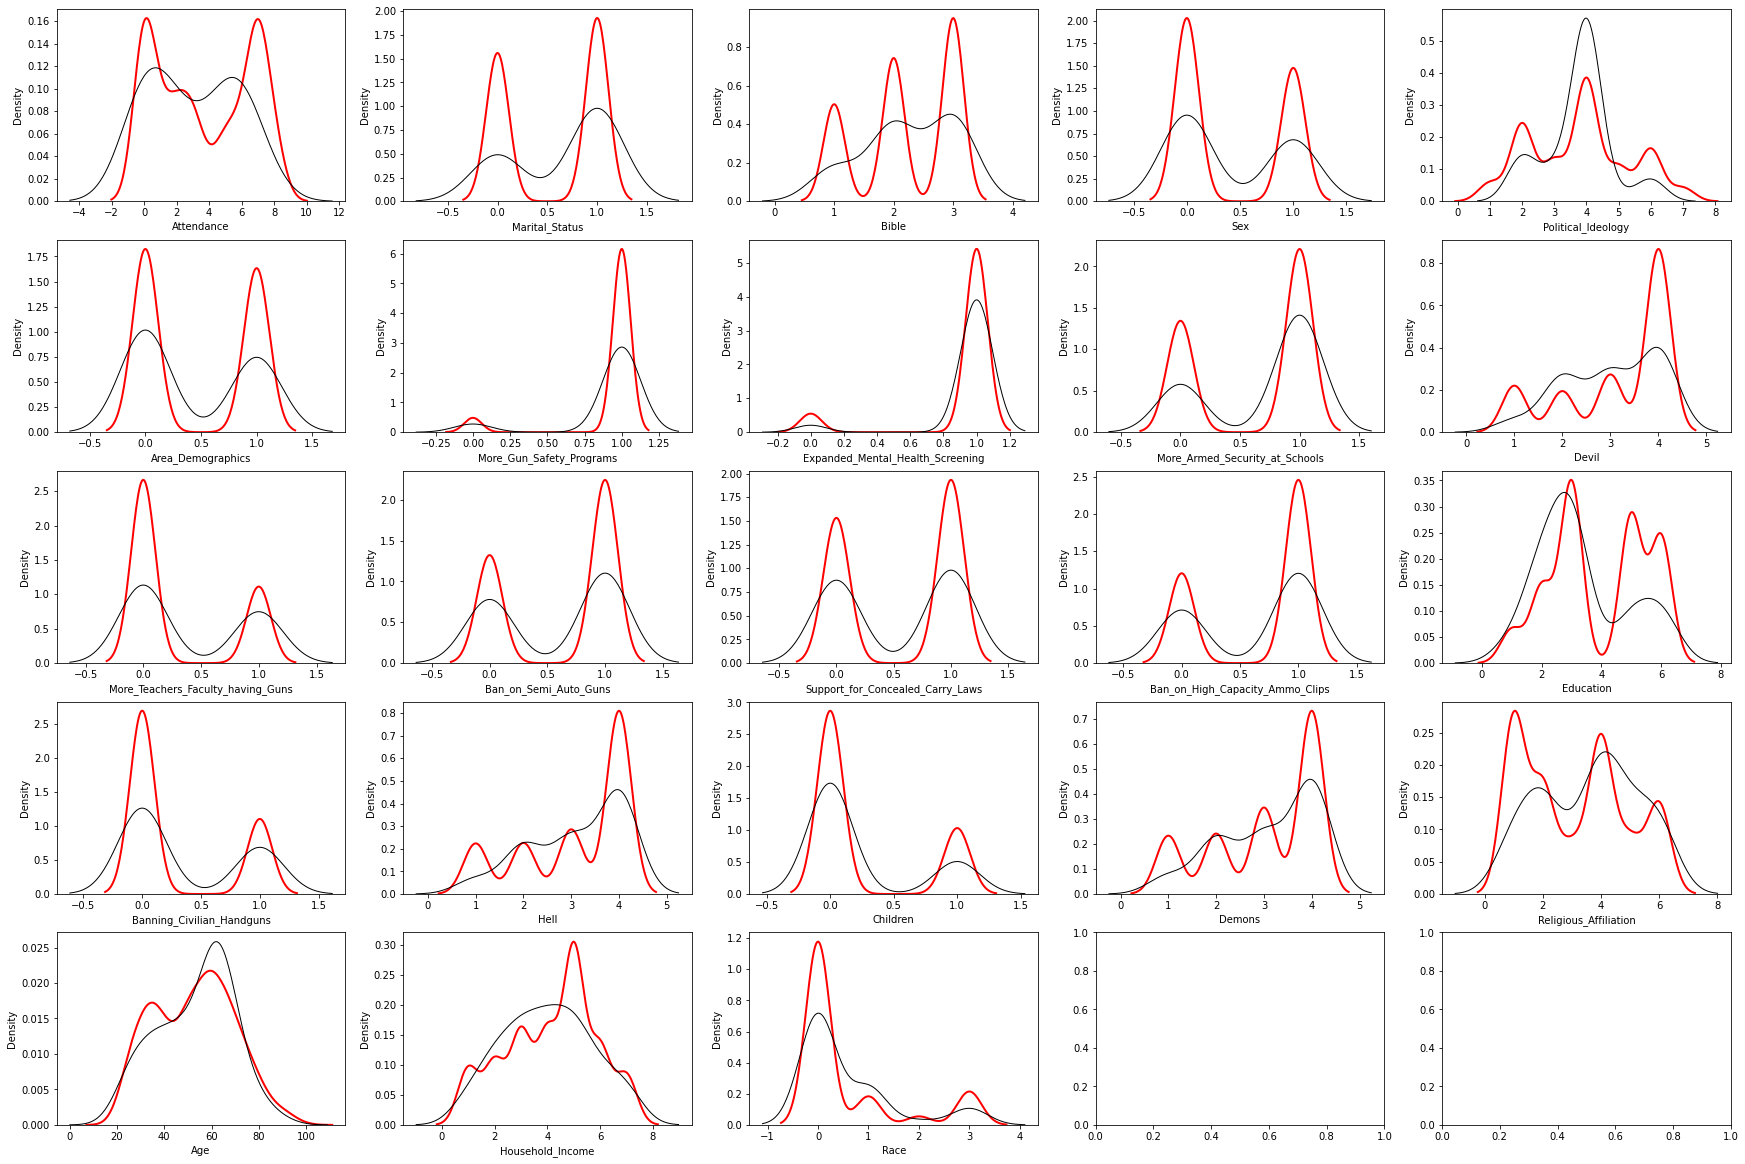

In [31]:
kernel.plot_imputed_distributions(right=4, top=4)

## Questions

The questions that will be answered in this assignment are:
1. Combine the questions regarding the belief in devil, hell and demons into one single metric.
2. Derive descriptive statistics for the variables and encode them to dummies when necessary.
3. Predict support for the various gun policies from the metric of supernatural evil, controlling for background variables.
4. Run a complementary series of linear regressions to estimate the strength of the various predictors.
5. Carry out predictions by using Decision Trees / Random Forests to check if the predictors, primarily the belief in supernatural evil, make also a strong showing with the best model.

### Q1: Belief in Supernatural Evil Metric

In this question we will investigate how the answers in the questions regarding the belief in devil, hell and demons can be combined into a single metric, that measures the belief in supernatural evil.

* From the imputed data we choose only the questions we need.

In [32]:
supernatural_evil = brs_data_imputed[['Devil', 'Hell', 'Demons']].copy()
supernatural_evil

,Devil,Hell,Demons
0,4.0,4.0,4.0
1,4.0,4.0,4.0
2,3.0,2.0,2.0
3,4.0,4.0,4.0
4,4.0,4.0,4.0
...,...,...,...
1567,4.0,2.0,4.0
1568,3.0,3.0,3.0
1569,4.0,4.0,3.0
1570,3.0,3.0,3.0


* PCA tries to diminish the dimensions (number of variables), by finding a smaller number of variables (we select the number), that contain the maximum of the original variation.
* The new variables are a linear combination of the original and they are called *Principal Components*. 
* Their coefficients are called *loadings* and they explain the contribution of each variable in the new PCs.

* We run a PCA in the three questions regarding the supernatural evil and we try to create only one dimension from these variables.

In [33]:
n_components = 1

pca = PCA(n_components=n_components, random_state=0)
supernatural_evil_single_metric = pca.fit(supernatural_evil).transform(supernatural_evil)

print('Explained variance ratio: ' + str(pca.explained_variance_ratio_))
print('Component coefficients: ' + str(pca.components_))

Explained variance ratio: [0.90120614]
Component coefficients: [[-0.58466387 -0.57835587 -0.56892236]]


* The PCA created one Principal Component that could explain 90% of the original variation, which is a big percentage.
* Also, we can notice that the loadings have almost equal values.
* This means that each question contributes equally in the new single dimension (Principal Component). This can be seen by the following equation:
$$PC = - 0.58466387 \times Devil - 0.57835587 \times Hell - 0.56892236 \times Demons $$
* As a result, we can make say that, since each question contributes equally in the creation of a single dimension that explains 90% of the variation, we can use the average of these three questions, which also uses equally each question and it's more explicable as a metric. 

In [34]:
supernatural_evil['Supernatural_Evil'] = supernatural_evil.mean(axis=1)
supernatural_evil

,Devil,Hell,Demons,Supernatural_Evil
0,4.0,4.0,4.0,4.000000
1,4.0,4.0,4.0,4.000000
2,3.0,2.0,2.0,2.333333
3,4.0,4.0,4.0,4.000000
4,4.0,4.0,4.0,4.000000
...,...,...,...,...
1567,4.0,2.0,4.0,3.333333
1568,3.0,3.0,3.0,3.000000
1569,4.0,4.0,3.0,3.666667
1570,3.0,3.0,3.0,3.000000


* We will also check that indeed the Principal Component created from the PCA is the same with the average.

In [35]:
supernatural_evil['Supernatural_Evil_PCA'] = supernatural_evil_single_metric
supernatural_evil

,Devil,Hell,Demons,Supernatural_Evil,Supernatural_Evil_PCA
0,4.0,4.0,4.0,4.000000,-1.584793
1,4.0,4.0,4.0,4.000000,-1.584793
2,3.0,2.0,2.0,2.333333,1.294428
3,4.0,4.0,4.0,4.000000,-1.584793
4,4.0,4.0,4.0,4.000000,-1.584793
...,...,...,...,...,...
1567,4.0,2.0,4.0,3.333333,-0.428081
1568,3.0,3.0,3.0,3.000000,0.147149
1569,4.0,4.0,3.0,3.666667,-1.015870
1570,3.0,3.0,3.0,3.000000,0.147149


* Because the signs of the loadings are negative and bigger values in the questions result in a smaller PC, we reverse it, without affecting the interpretation.

    *More information:* https://stats.stackexchange.com/questions/88880

In [36]:
supernatural_evil['Supernatural_Evil_PCA'] = - supernatural_evil['Supernatural_Evil_PCA']

* To make the comparison we rescale the PC to the range [1,4], by using the min-max scaler formula.

In [37]:
f = lambda x: (((x - supernatural_evil['Supernatural_Evil_PCA'].min()) * (4 - 1)) / (supernatural_evil['Supernatural_Evil_PCA'].max() - supernatural_evil['Supernatural_Evil_PCA'].min())) + 1
supernatural_evil['Supernatural_Evil_PCA'] = supernatural_evil['Supernatural_Evil_PCA'].apply(f)
supernatural_evil

,Devil,Hell,Demons,Supernatural_Evil,Supernatural_Evil_PCA
0,4.0,4.0,4.0,4.000000,4.000000
1,4.0,4.0,4.0,4.000000,4.000000
2,3.0,2.0,2.0,2.333333,2.337577
3,4.0,4.0,4.0,4.000000,4.000000
4,4.0,4.0,4.0,4.000000,4.000000
...,...,...,...,...,...
1567,4.0,2.0,4.0,3.333333,3.332130
1568,3.0,3.0,3.0,3.000000,3.000000
1569,4.0,4.0,3.0,3.666667,3.671512
1570,3.0,3.0,3.0,3.000000,3.000000


* Now, we can see that the difference between the average and the PC is extremely small and we can conclude that they describe the same thing.

In [38]:
abs(supernatural_evil['Supernatural_Evil']- supernatural_evil['Supernatural_Evil_PCA']).describe()

count    1572.000000
mean        0.001219
std         0.002555
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000602
max         0.014536
dtype: float64

* We append the new "Supernatural_Evil" metric to the DataFrame and we remove the questions from which it was created.

In [39]:
brs_data_imputed['Supernatural_Evil'] = supernatural_evil['Supernatural_Evil']
brs_data_imputed.drop(columns=['Devil', 'Hell', 'Demons'], inplace=True)
brs_data_imputed.head()

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Bible,...,Age,Sex,Education,Household_Income,Marital_Status,Children,Area_Demographics,Region,Race,Supernatural_Evil
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,85.0,0.0,5.0,2.0,0.0,0.0,1.0,1,0.0,4.000000
1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,21.0,0.0,3.0,1.0,0.0,1.0,0.0,1,1.0,4.000000
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,2.0,...,67.0,0.0,3.0,3.0,0.0,0.0,1.0,0,0.0,2.333333
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,6.0,2.0,...,64.0,0.0,3.0,2.0,0.0,0.0,0.0,1,0.0,4.000000
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,1.0,...,54.0,1.0,2.0,5.0,1.0,1.0,0.0,0,0.0,4.000000


* We perform the same to the non-imputed DataFrame because we will need it for the descriptive statistics later.

In [40]:
supernatural_evil_non_imputed = brs_data[['Devil', 'Hell', 'Demons']].copy()

brs_data['Supernatural_Evil'] = supernatural_evil_non_imputed.mean(axis=1)
brs_data.drop(columns=['Devil', 'Hell', 'Demons'], inplace=True)
brs_data.head()

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Bible,...,Age,Sex,Education,Household_Income,Marital_Status,Children,Area_Demographics,Region,Race,Supernatural_Evil
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,85.0,0.0,5.0,2.0,0.0,0.0,1.0,1,NaN,4.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,0.0,3.0,1.0,0.0,1.0,0.0,1,1.0,4.000000
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,2.0,...,67.0,0.0,3.0,3.0,0.0,0.0,1.0,0,0.0,2.333333
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,6.0,2.0,...,64.0,0.0,3.0,2.0,0.0,0.0,0.0,1,0.0,4.000000
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,1.0,...,54.0,1.0,2.0,5.0,1.0,1.0,0.0,0,0.0,4.000000


### Q2: Variables Selection

In this question we will encode the variables with dummies where needed and we will derive descriptive statistics for our dataset.

### Encode with Dummy Variables

* Before we derive the descriptives we will encode the nominal categorical variables with dummies.

* First, we encode the non-imputed DataFrame

In [41]:
brs_data_not_imputed_dummies = brs_data.copy()
brs_data_not_imputed_dummies.head()

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Bible,...,Age,Sex,Education,Household_Income,Marital_Status,Children,Area_Demographics,Region,Race,Supernatural_Evil
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,85.0,0.0,5.0,2.0,0.0,0.0,1.0,1,NaN,4.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,0.0,3.0,1.0,0.0,1.0,0.0,1,1.0,4.000000
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,2.0,...,67.0,0.0,3.0,3.0,0.0,0.0,1.0,0,0.0,2.333333
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,6.0,2.0,...,64.0,0.0,3.0,2.0,0.0,0.0,0.0,1,0.0,4.000000
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,1.0,...,54.0,1.0,2.0,5.0,1.0,1.0,0.0,0,0.0,4.000000


* The variables that need to be encoded are: "Bible", "Religious Affiliation", "Sex", "Race", "Education", "Marital Status", "Children", "Area Demographics" and "Region".
* We maintain the NaN values.
* We set understandable names for our dummies.
* We remove the old variables.

In [42]:
columns_for_dummies = ['Bible', 'Religious_Affiliation', 'Sex', 'Race', 'Education', 'Marital_Status', 'Children', 'Area_Demographics', 'Region']

dummies = pd.get_dummies(data=brs_data[columns_for_dummies], columns=columns_for_dummies)

# Maintain the NaN values, https://stackoverflow.com/questions/36653443
for col in columns_for_dummies:
    dummies.loc[brs_data[col].isnull(), dummies.columns.str.startswith(col + "_")] = np.nan

dummies.columns = ['Biblical_Literalism','Biblical_Inerrancy', 'Bible_Human_Error_History_and_Fables', 
'Conservative_Protestant', 'Mainline_Protestant', 'Black_Protestant', 'Catholic', 'Other_Religion', 'No_Affiliation',
'Female', 'Male', 'White', 'African_American_Black', 'Other_Race', 'Hispanic', 'Less_than_High_School', 
'High_School_or_Equivalent', 'Some_College', 'College_Graduate', 'Postgraduate', 'Not_Partnered_Single', 'Married_Cohabitating',
'No_Kids_Under_18', 'Kids_Under_18', 'Urban_Area', 'Small_Town_Rural', 'Other_Region', 'South']

brs_data_not_imputed_dummies = brs_data_not_imputed_dummies.join(dummies)

brs_data_not_imputed_dummies.drop(columns=columns_for_dummies, inplace=True)
brs_data_not_imputed_dummies.head()

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Political_Ideology,...,College_Graduate,Postgraduate,Not_Partnered_Single,Married_Cohabitating,No_Kids_Under_18,Kids_Under_18,Urban_Area,Small_Town_Rural,Other_Region,South
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,6.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,6.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,2.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


* The previous procedure is followed again for the imputed DataFrame.

In [43]:
brs_data_dummies = brs_data_imputed.copy()
brs_data_dummies.head()

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Bible,...,Age,Sex,Education,Household_Income,Marital_Status,Children,Area_Demographics,Region,Race,Supernatural_Evil
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,85.0,0.0,5.0,2.0,0.0,0.0,1.0,1,0.0,4.000000
1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,21.0,0.0,3.0,1.0,0.0,1.0,0.0,1,1.0,4.000000
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,2.0,...,67.0,0.0,3.0,3.0,0.0,0.0,1.0,0,0.0,2.333333
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,6.0,2.0,...,64.0,0.0,3.0,2.0,0.0,0.0,0.0,1,0.0,4.000000
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,1.0,...,54.0,1.0,2.0,5.0,1.0,1.0,0.0,0,0.0,4.000000


In [44]:
columns_for_dummies = ['Bible', 'Religious_Affiliation', 'Sex', 'Race', 'Education', 'Marital_Status', 'Children', 'Area_Demographics', 'Region']

dummies = pd.get_dummies(data=brs_data_imputed[columns_for_dummies], columns=columns_for_dummies)

dummies.columns = ['Biblical_Literalism','Biblical_Inerrancy', 'Bible_Human_Error_History_and_Fables', 
'Conservative_Protestant', 'Mainline_Protestant', 'Black_Protestant', 'Catholic', 'Other_Religion', 'No_Affiliation',
'Female', 'Male', 'White', 'African_American_Black', 'Other_Race', 'Hispanic', 'Less_than_High_School', 
'High_School_or_Equivalent', 'Some_College', 'College_Graduate', 'Postgraduate', 'Not_Partnered_Single', 'Married_Cohabitating',
'No_Kids_Under_18', 'Kids_Under_18', 'Urban_Area', 'Small_Town_Rural', 'Other_Region', 'South']

brs_data_dummies = brs_data_dummies.join(dummies)

brs_data_dummies.drop(columns=columns_for_dummies, inplace=True)
brs_data_dummies.head()

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Political_Ideology,...,College_Graduate,Postgraduate,Not_Partnered_Single,Married_Cohabitating,No_Kids_Under_18,Kids_Under_18,Urban_Area,Small_Town_Rural,Other_Region,South
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,1,0,1,0,1,0,0,1,0,1
1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,...,0,0,1,0,0,1,1,0,0,1
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,6.0,...,0,0,1,0,1,0,0,1,1,0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,6.0,2.0,...,0,0,1,0,1,0,1,0,0,1
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,2.0,...,0,0,0,1,0,1,1,0,1,0


* Here are the final columns of the DataFrames.

In [45]:
brs_data_dummies.columns

Index(['Ban_on_Semi_Auto_Guns', 'Ban_on_High_Capacity_Ammo_Clips',
       'Banning_Civilian_Handguns', 'Support_for_Concealed_Carry_Laws',
       'More_Armed_Security_at_Schools', 'More_Teachers_Faculty_having_Guns',
       'More_Gun_Safety_Programs', 'Expanded_Mental_Health_Screening',
       'Attendance', 'Political_Ideology', 'Age', 'Household_Income',
       'Supernatural_Evil', 'Biblical_Literalism', 'Biblical_Inerrancy',
       'Bible_Human_Error_History_and_Fables', 'Conservative_Protestant',
       'Mainline_Protestant', 'Black_Protestant', 'Catholic', 'Other_Religion',
       'No_Affiliation', 'Female', 'Male', 'White', 'African_American_Black',
       'Other_Race', 'Hispanic', 'Less_than_High_School',
       'High_School_or_Equivalent', 'Some_College', 'College_Graduate',
       'Postgraduate', 'Not_Partnered_Single', 'Married_Cohabitating',
       'No_Kids_Under_18', 'Kids_Under_18', 'Urban_Area', 'Small_Town_Rural',
       'Other_Region', 'South'],
      dtype='object')

### Descriptive Statistics

* We derive descriptive statistics for all our variables, for both imputed and non-imputed DataFrames.
* For the nominal variables we derive percentages and for the ordinals and numericals we derive the mean and the standard deviation.

#### Gun Policies

##### Original Data

In [46]:
for i in range(0,8):
    print('{}: {:.1f} %'.format(brs_data_not_imputed_dummies.columns[i], brs_data_not_imputed_dummies[brs_data.columns[i]].mean() * 100))

Ban_on_Semi_Auto_Guns: 62.9 %
Ban_on_High_Capacity_Ammo_Clips: 67.1 %
Banning_Civilian_Handguns: 29.0 %
Support_for_Concealed_Carry_Laws: 55.8 %
More_Armed_Security_at_Schools: 62.2 %
More_Teachers_Faculty_having_Guns: 29.5 %
More_Gun_Safety_Programs: 92.7 %
Expanded_Mental_Health_Screening: 90.8 %


##### Imputed Data

In [47]:
for i in range(0,8):
    print('{}: {:.1f} %'.format(brs_data_dummies.columns[i], brs_data_dummies[brs_data.columns[i]].mean() * 100))

Ban_on_Semi_Auto_Guns: 62.7 %
Ban_on_High_Capacity_Ammo_Clips: 66.9 %
Banning_Civilian_Handguns: 29.3 %
Support_for_Concealed_Carry_Laws: 55.7 %
More_Armed_Security_at_Schools: 62.5 %
More_Teachers_Faculty_having_Guns: 29.9 %
More_Gun_Safety_Programs: 92.7 %
Expanded_Mental_Health_Screening: 91.0 %


#### Supernatural Evil

##### Original Data

In [48]:
print('{}: {:.2f}(mean), {:.2f}(std)'.format(brs_data_not_imputed_dummies['Supernatural_Evil'].name, 
        brs_data_not_imputed_dummies['Supernatural_Evil'].mean(), np.std(brs_data_not_imputed_dummies['Supernatural_Evil'])))

Supernatural_Evil: 3.09(mean), 1.05(std)


##### Imputed Data

In [49]:
print('{}: {:.2f}(mean), {:.2f}(std)'.format(brs_data_dummies['Supernatural_Evil'].name, 
        brs_data_dummies['Supernatural_Evil'].mean(), np.std(brs_data_dummies['Supernatural_Evil'])))

Supernatural_Evil: 3.08(mean), 1.05(std)


#### Attendance

##### Original Data

In [50]:
print('{}: {:.2f}(mean), {:.2f}(std)'.format(brs_data_not_imputed_dummies['Attendance'].name, 
        brs_data_not_imputed_dummies['Attendance'].mean(), np.std(brs_data_not_imputed_dummies['Attendance'])))

Attendance: 3.68(mean), 2.93(std)


##### Imputed Data

In [51]:
print('{}: {:.2f}(mean), {:.2f}(std)'.format(brs_data_dummies['Attendance'].name, 
        brs_data_dummies['Attendance'].mean(), np.std(brs_data_dummies['Attendance'])))

Attendance: 3.67(mean), 2.93(std)


#### Bible

##### Original Data

In [52]:
bible_cat = ['Bible_Human_Error_History_and_Fables', 'Biblical_Inerrancy', 'Biblical_Literalism']
for cat in bible_cat:
    print('{}: {:.1f} %'.format(brs_data_not_imputed_dummies[cat].name, (brs_data_not_imputed_dummies[cat].mean()) * 100))

Bible_Human_Error_History_and_Fables: 43.3 %
Biblical_Inerrancy: 33.8 %
Biblical_Literalism: 22.9 %


##### Imputed Data

In [53]:
for cat in bible_cat:
    print('{}: {:.1f} %'.format(brs_data_dummies[cat].name, (brs_data_dummies[cat].mean()) * 100))

Bible_Human_Error_History_and_Fables: 43.3 %
Biblical_Inerrancy: 33.9 %
Biblical_Literalism: 22.8 %


#### Religious Affiliation

##### Original Data

In [54]:
religious_cat = ['Conservative_Protestant', 'Mainline_Protestant', 'Black_Protestant', 'Catholic', 'Other_Religion', 'No_Affiliation']
for cat in religious_cat:
    print('{}: {:.1f} %'.format(brs_data_not_imputed_dummies[cat].name, (brs_data_not_imputed_dummies[cat].mean()) * 100))

Conservative_Protestant: 28.4 %
Mainline_Protestant: 16.9 %
Black_Protestant: 7.2 %
Catholic: 24.9 %
Other_Religion: 8.2 %
No_Affiliation: 14.4 %


##### Imputed Data

In [55]:
for cat in religious_cat:
    print('{}: {:.1f} %'.format(brs_data_dummies[cat].name, (brs_data_dummies[cat].mean()) * 100))

Conservative_Protestant: 27.5 %
Mainline_Protestant: 17.1 %
Black_Protestant: 7.1 %
Catholic: 25.2 %
Other_Religion: 8.5 %
No_Affiliation: 14.6 %


#### Political Ideology

##### Original Data

In [56]:
print('{}: {:.2f}(mean), {:.2f}(std)'.format(brs_data_not_imputed_dummies['Political_Ideology'].name, 
        brs_data_not_imputed_dummies['Political_Ideology'].mean(), np.std(brs_data_not_imputed_dummies['Political_Ideology'])))

Political_Ideology: 3.80(mean), 1.55(std)


##### Imputed Data

In [57]:
print('{}: {:.2f}(mean), {:.2f}(std)'.format(brs_data_dummies['Political_Ideology'].name, 
        brs_data_dummies['Political_Ideology'].mean(), np.std(brs_data_dummies['Political_Ideology'])))

Political_Ideology: 3.80(mean), 1.54(std)


#### Age

##### Original Data

In [58]:
print('{}: {:.2f}(mean), {:.2f}(std)'.format(brs_data_not_imputed_dummies['Age'].name, 
        brs_data_not_imputed_dummies['Age'].mean(), np.std(brs_data_not_imputed_dummies['Age'])))

Age: 52.65(mean), 17.01(std)


##### Imputed Data

In [59]:
print('{}: {:.2f}(mean), {:.2f}(std)'.format(brs_data_dummies['Age'].name, 
        brs_data_dummies['Age'].mean(), np.std(brs_data_dummies['Age'])))

Age: 52.68(mean), 16.94(std)


#### Sex

##### Original Data

In [60]:
sex_cat = ['Female', 'Male']
for cat in sex_cat:
    print('{}: {:.1f} %'.format(brs_data_not_imputed_dummies[cat].name, (brs_data_not_imputed_dummies[cat].mean()) * 100))

Female: 57.9 %
Male: 42.1 %


##### Imputed Data

In [61]:
for cat in sex_cat:
    print('{}: {:.1f} %'.format(brs_data_dummies[cat].name, (brs_data_dummies[cat].mean()) * 100))

Female: 57.9 %
Male: 42.1 %


#### Race

##### Original Data

In [62]:
race_cat = ['White', 'African_American_Black', 'Hispanic', 'Other_Race']
for cat in race_cat:
    print('{}: {:.1f} %'.format(brs_data_not_imputed_dummies[cat].name, (brs_data_not_imputed_dummies[cat].mean()) * 100))

White: 72.2 %
African_American_Black: 11.2 %
Hispanic: 13.2 %
Other_Race: 3.4 %


##### Imputed Data

In [63]:
race_cat = ['White', 'African_American_Black', 'Hispanic', 'Other_Race']
for cat in race_cat:
    print('{}: {:.1f} %'.format(brs_data_dummies[cat].name, (brs_data_dummies[cat].mean()) * 100))

White: 71.8 %
African_American_Black: 12.0 %
Hispanic: 12.9 %
Other_Race: 3.3 %


#### Education

##### Original Data

In [64]:
edu_cat = ['Less_than_High_School', 'High_School_or_Equivalent', 'Some_College', 'College_Graduate', 'Postgraduate']
for cat in edu_cat:
    print('{}: {:.1f} %'.format(brs_data_not_imputed_dummies[cat].name, (brs_data_not_imputed_dummies[cat].mean()) * 100))

Less_than_High_School: 5.9 %
High_School_or_Equivalent: 13.4 %
Some_College: 32.2 %
College_Graduate: 26.2 %
Postgraduate: 22.3 %


##### Imputed Data

In [65]:
for cat in edu_cat:
    print('{}: {:.1f} %'.format(brs_data_dummies[cat].name, (brs_data_dummies[cat].mean()) * 100))

Less_than_High_School: 5.9 %
High_School_or_Equivalent: 13.9 %
Some_College: 32.6 %
College_Graduate: 25.6 %
Postgraduate: 21.9 %


#### Household Income

##### Original Data

In [66]:
print('{}: {:.2f}(mean), {:.2f}(std)'.format(brs_data_not_imputed_dummies['Household_Income'].name, 
        brs_data_not_imputed_dummies['Household_Income'].mean(), np.std(brs_data_not_imputed_dummies['Household_Income'])))

Household_Income: 4.15(mean), 1.71(std)


##### Imputed Data

In [67]:
print('{}: {:.2f}(mean), {:.2f}(std)'.format(brs_data_dummies['Household_Income'].name, 
        brs_data_dummies['Household_Income'].mean(), np.std(brs_data_dummies['Household_Income'])))

Household_Income: 4.14(mean), 1.70(std)


#### Marital Status

##### Original Data

In [68]:
marital_cat = ['Not_Partnered_Single', 'Married_Cohabitating']
for cat in marital_cat:
    print('{}: {:.1f} %'.format(brs_data_not_imputed_dummies[cat].name, (brs_data_not_imputed_dummies[cat].mean()) * 100))

Not_Partnered_Single: 44.7 %
Married_Cohabitating: 55.3 %


##### Imputed Data

In [69]:
marital_cat = ['Not_Partnered_Single', 'Married_Cohabitating']
for cat in marital_cat:
    print('{}: {:.1f} %'.format(brs_data_dummies[cat].name, (brs_data_dummies[cat].mean()) * 100))

Not_Partnered_Single: 44.6 %
Married_Cohabitating: 55.4 %


#### Children

##### Original Data

In [70]:
children_cat = ['No_Kids_Under_18', 'Kids_Under_18']
for cat in children_cat:
    print('{}: {:.1f} %'.format(brs_data_not_imputed_dummies[cat].name, (brs_data_not_imputed_dummies[cat].mean()) * 100))

No_Kids_Under_18: 73.5 %
Kids_Under_18: 26.5 %


##### Imputed Data

In [71]:
for cat in children_cat:
    print('{}: {:.1f} %'.format(brs_data_dummies[cat].name, (brs_data_dummies[cat].mean()) * 100))

No_Kids_Under_18: 73.7 %
Kids_Under_18: 26.3 %


#### Area Demographics

##### Original Data

In [72]:
area_cat = ['Small_Town_Rural', 'Urban_Area']
for cat in area_cat:
    print('{}: {:.1f} %'.format(brs_data_not_imputed_dummies[cat].name, (brs_data_not_imputed_dummies[cat].mean()) * 100))

Small_Town_Rural: 47.2 %
Urban_Area: 52.8 %


##### Imputed Data

In [73]:
for cat in area_cat:
    print('{}: {:.1f} %'.format(brs_data_dummies[cat].name, (brs_data_dummies[cat].mean()) * 100))

Small_Town_Rural: 47.1 %
Urban_Area: 52.9 %


#### Region

##### Original Data

In [74]:
region_cat = ['South', 'Other_Region']
for cat in region_cat:
    print('{}: {:.1f} %'.format(brs_data_not_imputed_dummies[cat].name, (brs_data_not_imputed_dummies[cat].mean()) * 100))

South: 38.7 %
Other_Region: 61.3 %


##### Imputed Data

In [75]:
for cat in region_cat:
    print('{}: {:.1f} %'.format(brs_data_dummies[cat].name, (brs_data_dummies[cat].mean()) * 100))

South: 38.7 %
Other_Region: 61.3 %


### Q3: Predict Support for Various Gun Policies

In this question we will predict support for the various gun policies from the metric of supernatural evil, by controlling background variables.

* As the study mentions, after reviewing the literature we end up with two hypotheses:
    1. We expect that the belief in supernatural evil will be associated with more liberal gun policy attitudes (i.e., those that increase the availability of firearms to civilians)
    2. We expect that the above associations between supernatural evil and more liberal gun policy attitudes will be partly mediated by political ideology. 

* To estimate the support we will run binary logistic regressions for each gun policy.
* Our focal variable is "Superantural Evil", we want to see how it affects the several gun policies and how this changes with the addition of "Political Ideology".
* For each gun policy we will run two logistic regressions:
    * In the first, we will use only religious predictors that have been linked with gun ownership or policy attitudes.
    * In the second, we will add some more background variables that are known correlates of gun ownership and policy preference, including "Political Ideology".

* First, we create a list with all the predictors that we need to run the regressions

In [76]:
pred = ['Supernatural_Evil', 'Attendance', 'Biblical_Inerrancy', 'Biblical_Literalism', 'Mainline_Protestant', 'Black_Protestant', 'Conservative_Protestant', 'Catholic', 
    'Other_Religion', 'Political_Ideology', 'African_American_Black', 'Hispanic', 'Other_Race', 'Female', 'Less_than_High_School', 'Some_College', 'College_Graduate', 
    'Postgraduate', 'Age', 'Household_Income', 'Married_Cohabitating', 'Kids_Under_18', 'Urban_Area' , 'South']

* We also create the two formulas that will be used to run the regressions using the `statsmodels` library.
    1. Only the religious variables.
    2. The religious variables and the covariates together.

In [77]:
religious_terms = ' + '.join(f'{x}' for x in pred[:9])
religious_and_covariates_terms = ' + '.join(f'{x}' for x in pred)
religious_formula = ' ~ ' + religious_terms 
religious_and_covariates_formula = ' ~ ' + religious_and_covariates_terms
religious_and_covariates_formula

' ~ Supernatural_Evil + Attendance + Biblical_Inerrancy + Biblical_Literalism + Mainline_Protestant + Black_Protestant + Conservative_Protestant + Catholic + Other_Religion + Political_Ideology + African_American_Black + Hispanic + Other_Race + Female + Less_than_High_School + Some_College + College_Graduate + Postgraduate + Age + Household_Income + Married_Cohabitating + Kids_Under_18 + Urban_Area + South'

* The results of the regressions will be saved in a dictionary.
* We create a list with the names of all the dependent variables, to be used as keys in the dictionary.

In [78]:
logistic_regressions_dict = {}
dependent_variables = list(brs_data_dummies.columns[0:8])

* Now, we run for every dependent variable a logistic regression (method `logit`), with only the religious predictors.
* In the dictionary we create a key-value pair with key the name of the dependent variable and for value a new dictionary that has for key the word "religious" and for value a list with a DataFrame, containing the **odds ratios** and the **p-values**, and the predicted probabilities.
* The form of the dictionary is:
    1. dictionary["dependent_variable"]["type_of_predictors"][0], for the DataFrame.
    2. dictionary["dependent_variable"]["type_of_predictors"][1], for the propabilties.

In [79]:
for var in dependent_variables:
    # Run the model
    regression_religious = smf.logit(var + religious_formula, brs_data_dummies).fit(disp=0)

    # Get the predicted probabilities.
    probabilities = regression_religious.predict(brs_data_dummies[pred[0:9]])

    # Extract the odds ratios
    odds_ratio_religious = round(np.exp(regression_religious.params[1:]),2)
    # Extract the p-values
    p_values_religious = round(regression_religious.pvalues[1:],4)

    # Save in a DataFrame
    religious_df = pd.concat([odds_ratio_religious, p_values_religious], axis=1)
    religious_df.columns = ['OR','P-Values']
    
    logistic_regressions_dict[var] = {'religious': [religious_df, probabilities]}

* The same procedure is done with the second formula, where there are all the religious variables and the covariates together.
* In this case we add in the previously created dictionary a second key-value pair with key "religious_and_covariates" this time.

In [80]:
for var in dependent_variables:
    # Run the model
    regression_religious_covariates = smf.logit(var + religious_and_covariates_formula, brs_data_dummies).fit(disp=0)

    # Get the predicted probabilities.
    probabilities = regression_religious_covariates.predict(brs_data_dummies[pred])

    # Extract the odds ratios
    odds_ratio_religious_covariates = round(np.exp(regression_religious_covariates.params[1:]),2)
    # Extract the p-values
    p_values_religious_covariates = round(regression_religious_covariates.pvalues[1:],4)

    # Save in a DataFrame
    religious_covariates_df = pd.concat([odds_ratio_religious_covariates, p_values_religious_covariates], axis=1)
    religious_covariates_df.columns = ['OR','P-Values']

    logistic_regressions_dict[var]['religious_and_covariates'] = [religious_covariates_df, probabilities]

* We have run all the logistic regressions and now we will review and discuss the results.

    (Odds Ratio indicates the change of the likeliness of an outcome, while the value of the variable increases.)

#### Ban on Semi-Auto Guns

In [81]:
logistic_regressions_dict['Ban_on_Semi_Auto_Guns']['religious'][0]

,OR,P-Values
Supernatural_Evil,0.72,0.0000
Attendance,1.04,0.0771
Biblical_Inerrancy,1.10,0.5372
Biblical_Literalism,1.10,0.5997
Mainline_Protestant,1.14,0.5458
Black_Protestant,1.62,0.0987
Conservative_Protestant,0.93,0.7519
Catholic,1.28,0.2409
Other_Religion,1.84,0.0189


In the first logistic regression for the "Ban on Semi-Auto Guns" policy, we notice that: 
* "Supernatural_Evil" is a strong predictor and suggests that believing in supernatural evil is associated with a 28% decline in the odds of supporting the ban of semi-automated guns. It is also statistically significant with very strong evidence, p < 0.001.
* "Other_Religion" is statistically significant as well, with moderate evidence p = 0.02 and suggests that someone who is something other than mainline protestant, black protestant, conservative protestant or catholic, is 84% more likely to vote in favor of banning semi-automated guns. 
* Also, a "Black_Protestant" seems to be 62% more likely of voting in favor of banning semi-automated guns, but it is not statistically significant.

In [82]:
logistic_regressions_dict['Ban_on_Semi_Auto_Guns']['religious_and_covariates'][0]

,OR,P-Values
Supernatural_Evil,0.82,0.0210
Attendance,1.06,0.0344
Biblical_Inerrancy,1.17,0.3567
Biblical_Literalism,1.28,0.2415
Mainline_Protestant,1.08,0.7537
Black_Protestant,1.18,0.6634
Conservative_Protestant,1.25,0.4013
Catholic,1.26,0.3311
Other_Religion,1.57,0.1230
Political_Ideology,1.69,0.0000


In the second logistic regression for the "Ban on Semi-Auto Guns" policy, we notice that: 
* "Supernatural_Evil" remains statistically significant but the strength of the significance reduced to p = 0.02. Also, we see that the relationship that decreases the likelihood of voting in favor of the ban of semi-automated guns diminished slightly to 18%.
* "Political_Ideology" seems to be a strong predictor that suggests a 69% increase in the odds for the support of banning semi-automated guns. It is also statistically significant with very strong evidence, p < 0.001.
* "Female" is another very strong predictor that suggests a 235% odds increase and in the same time it is statistically significant with p < 0.001.
* "Age" is also statistically significant with p < 0.001, although it is not a strong predictor since it suggests an only 3% increase.
* "Urban_Are" is a fair predictor that suggests a 40% likelihood increase for the support. Simultaneously is statistically significant.
* "South", similarly, looks like a good predictor with a 30% decrease in the odds of supporting and a strong statistically significance.
* Lastly, "Household_Income" and "Attendance" are smaller predictors that suggest an 11% and a 6%  increase, respectively.


#### Ban on High-Capacity Ammo Clips

In [83]:
logistic_regressions_dict['Ban_on_High_Capacity_Ammo_Clips']['religious'][0]

,OR,P-Values
Supernatural_Evil,0.71,0.0000
Attendance,1.05,0.0619
Biblical_Inerrancy,1.14,0.4117
Biblical_Literalism,1.09,0.6480
Mainline_Protestant,1.15,0.5239
Black_Protestant,1.68,0.0867
Conservative_Protestant,0.95,0.8206
Catholic,1.29,0.2404
Other_Religion,1.66,0.0566


In the first logistic regression for the "Ban on High-Capacity Ammo Clips" policy, we notice that: 
* "Supernatural_Evil" like in the previous policy is a strong predictor and suggests that believing in supernatural evil is associated with a 29% decline in the odds of supporting the ban on high-capacity ammo clips. It is also statistically significant with very strong evidence, p < 0.001.
* "Other_Religion" and "Black_Protestant" seem also good predictors with 66% and 68% likeliness increase in the support,but they are moderate statistically significant.

In [84]:
logistic_regressions_dict['Ban_on_High_Capacity_Ammo_Clips']['religious_and_covariates'][0]

,OR,P-Values
Supernatural_Evil,0.80,0.0089
Attendance,1.06,0.0362
Biblical_Inerrancy,1.21,0.2625
Biblical_Literalism,1.14,0.5457
Mainline_Protestant,1.03,0.9204
Black_Protestant,1.05,0.8967
Conservative_Protestant,1.16,0.5742
Catholic,1.25,0.3515
Other_Religion,1.36,0.2944
Political_Ideology,1.58,0.0000


In the second logistic regression for the "Ban on High-Capacity Ammo Clips" policy, we notice that: 
* "Supernatural_Evil" again remains statistically significant, however, the strength of the significance slightly reduced to p = 0.008. Also, we see that the relationship that decreases the likelihood of voting in favor of the ban of high-capacity ammo clips diminished to 20%.
* "Political_Ideology" seems to be a strong predictor, as well, that suggests a 58% increase in the odds of supporting the ban for high-capacity ammo clips. It is also statistically significant with very strong evidence, p < 0.001.
* "Female" is again the strongest predictor that suggests a 294% increase in the supporting odds and in the same time it is statistically significant with p < 0.001.
* "Age" is also statistically significant with p < 0.001, although it is not a strong predictor since it suggests an only 3% increase.
* "Urban_Are" is a fair predictor that suggests a 44% likelihood increase in support and is simultaneously statistically significant.
* Lastly, "Attendance" is a weak predictor that suggests a 6% increase.

#### Cilivian Hand Gun Possession Ban

In [85]:
logistic_regressions_dict['Banning_Civilian_Handguns']['religious'][0]

,OR,P-Values
Supernatural_Evil,0.68,0.0000
Attendance,1.05,0.0534
Biblical_Inerrancy,0.99,0.9706
Biblical_Literalism,1.36,0.1282
Mainline_Protestant,0.70,0.1214
Black_Protestant,2.40,0.0026
Conservative_Protestant,0.68,0.1277
Catholic,1.31,0.2096
Other_Religion,1.65,0.0382


In the first logistic regression for the "Cilivian Hand Gun Possession Ban" policy, we notice that: 
* "Supernatural_Evil" is a strong predictor, stronger than before, and suggests that believing in supernatural evil is associated with a 32% decline in the likeliness of supporting the cilivian hand gun possession ban. It is also statistically significant with very strong evidence, p < 0.001.
* "Black_Protestant" this time is a strong predictor, that suggests a 140% increase in the odds of supporting the ban and has strong statistically significance too.
* "Other_Religion" seems also a good predictor with 65% increase in the support likelihood and a good statistically significance.

In [86]:
logistic_regressions_dict['Banning_Civilian_Handguns']['religious_and_covariates'][0]

,OR,P-Values
Supernatural_Evil,0.73,0.0003
Attendance,1.07,0.0207
Biblical_Inerrancy,1.00,0.9956
Biblical_Literalism,1.37,0.1488
Mainline_Protestant,0.80,0.3789
Black_Protestant,1.93,0.0717
Conservative_Protestant,0.88,0.6295
Catholic,1.13,0.6066
Other_Religion,1.50,0.1176
Political_Ideology,1.37,0.0000


In the second logistic regression for the "Cilivian Hand Gun Possession Ban" policy, we notice that: 
* "Supernatural_Evil" again remains statistically significant, however, the strength of the significance didn't reduce, p < 0.001. Also, we see that the relationship that decreases the likelihood of voting in favor of the cilivian hand gun possession ban slightly diminished to 27%.
* "Political_Ideology" seems to be a good predictor, smaller this time, and suggests a 37% increase in the odds of supporting the civilian handguns ban. It is also statistically significant with very strong evidence, p < 0.001.
* "Female" is a predictor much smaller than in the other policies, and suggests a 46% increase in the support likeliness. In the same time it is statistically significant with p = 0.003.
* "Age" is again statistically significant with p < 0.001, although it is a very weak predictor since it suggests an only 1% increase.
* "Hispanic" and "Other_Race" play a very important role this time by suggesting a 210% and a 235% increase, accordingly, with a very strong statistically significance.
* "Urban_Are" is a fair predictor that suggests a 37% odds increase and is also statistically significant.
* Lastly, "Attendance" is one more time a weak predictor that suggests a 7% increase in the odds of supporting the ban.

#### Support for Concealed Carry Laws

In [87]:
logistic_regressions_dict['Support_for_Concealed_Carry_Laws']['religious'][0]

,OR,P-Values
Supernatural_Evil,1.55,0.0000
Attendance,0.98,0.3345
Biblical_Inerrancy,0.72,0.0308
Biblical_Literalism,0.93,0.7045
Mainline_Protestant,1.02,0.9222
Black_Protestant,0.43,0.0027
Conservative_Protestant,1.08,0.7344
Catholic,0.67,0.0455
Other_Religion,0.57,0.0162


In the first logistic regression for the "Support for Concealed Carry Laws" policy, we notice that: 
* "Supernatural_Evil" is a strong predictor and suggests that believing in supernatural evil is associated with a 55% increase, this time, in the likeliness of supporting concealed carry laws. It is also statistically significant with very strong evidence, p < 0.001.
* "Black_Protestant" is again a strong predictor, that suggests a 57% decrease in the odds of supporting for the laws and has strong statistically significance too.
* "Other_Religion" seems also a good predictor with 43% decrease in the likeliness of supporting and a good statistically significance.
* Lastly, "Catholic" and "Biblical_Inerrancy" this time are significant predictors, suggesting a 33% and a 28% decrease in support odds for concealed carry laws, accordingly.

In [88]:
logistic_regressions_dict['Support_for_Concealed_Carry_Laws']['religious_and_covariates'][0]

,OR,P-Values
Supernatural_Evil,1.41,0.0000
Attendance,0.96,0.1373
Biblical_Inerrancy,0.63,0.0050
Biblical_Literalism,0.79,0.2349
Mainline_Protestant,0.99,0.9552
Black_Protestant,0.44,0.0217
Conservative_Protestant,0.86,0.5566
Catholic,0.68,0.0801
Other_Religion,0.64,0.0865
Political_Ideology,0.67,0.0000


In the second logistic regression for the "Support for Concealed Carry Laws" policy, we notice that: 
* "Supernatural_Evil" again remains with a very strong statistically significance and we see that the relationship that decreases the likelihood of voting in favor of the the laws for concealed carry slightly diminished to 41%.
* "Political_Ideology" is a good predictor, with again smaller impact, and suggests a 33% likelihood decrease in the support for concealed carry laws. It is also statistically significant with very strong evidence, p < 0.001.
* "Female" is one more time a strong predictor and suggests a 55% decrease in the odds of supporting the laws. In the same time it has very strong evidence of statistically significance, with p < 0.001.
* "Age" is less statistically significant this time, with p = 0.02, and in the same a very weak predictor since it suggests an only 1% decrease.
* For this policy there are a lot of other significant predictors that sugggest a decrease in the support likeliness for concealed carry laws, specifiacally: "Black_Protestant", "Hispanic", "Biblical_Inerrancy" and "Urban_Area", with the last two being strongly significant.
* Lastly, "South" is another good significant predictor that suggests a 42% increase in the odds.

#### More Armed Security at Schools           

In [89]:
logistic_regressions_dict['More_Armed_Security_at_Schools']['religious'][0]

,OR,P-Values
Supernatural_Evil,1.61,0.0000
Attendance,0.92,0.0015
Biblical_Inerrancy,1.14,0.3764
Biblical_Literalism,2.09,0.0002
Mainline_Protestant,1.26,0.2775
Black_Protestant,1.66,0.1016
Conservative_Protestant,1.24,0.3503
Catholic,1.24,0.2884
Other_Religion,1.11,0.6637


In the first logistic regression for the "More Armed Security at Schools" policy, we notice that: 
* "Supernatural_Evil" is a strong predictor and suggests that believing in supernatural evil is associated with a 65% increase in the support likelihood for more armed security at schools. It is also statistically significant, with very strong evidence, p < 0.001.
* "Biblical_Literalism" is this time a strong predictor, that suggests a 109% increase in the odds of supporting for more armed security and has a very strong statistically significance too.
* "Attendance" seems to be a medium predictor with 8% decrease in the likeliness of supporting the policy and a has strong statistically significance.

In [90]:
logistic_regressions_dict['More_Armed_Security_at_Schools']['religious_and_covariates'][0]

,OR,P-Values
Supernatural_Evil,1.36,0.0001
Attendance,0.93,0.0046
Biblical_Inerrancy,1.05,0.7390
Biblical_Literalism,1.63,0.0216
Mainline_Protestant,1.41,0.1229
Black_Protestant,1.68,0.1645
Conservative_Protestant,1.14,0.6015
Catholic,1.35,0.1572
Other_Religion,1.42,0.1602
Political_Ideology,0.79,0.0000


In the second logistic regression for the "More Armed Security at Schools" policy, we notice that: 
* "Supernatural_Evil", one more time, remains with a very strong statistically significance, but we see that the likelihood of supporting the increase of armed security at schools diminished to 36%.
* "Political_Ideology" is a good predictor, with a smaller impact like before, and suggests a 21% decrease in the support odds for more armed security. It is also statistically significant with very strong evidence, p < 0.001.
* "Age" is less statistically significant again, with p = 0.03, and in the same time a very weak predictor, since it suggests an only 1% decrease.
* "Postgraduate", seems to be a good predictor for this policy, suggesting that is 52% more likely to be against the policy and also has a very strong statistically significance. 
* "South", similarly to the previous policy, is another good significant predictor that suggests a 53% increase in the likeliness of supporting the more armed security at schools.
* Lastly, some other significant predictors are: "Household_Income" and "Attendance", which suggest a small decrease, and "Biblical_Literalism", which suggests an increase of 63%.

#### More Teachers/Faculty having Guns

In [91]:
logistic_regressions_dict['More_Teachers_Faculty_having_Guns']['religious'][0]

,OR,P-Values
Supernatural_Evil,1.49,0.0000
Attendance,0.95,0.0319
Biblical_Inerrancy,0.85,0.3060
Biblical_Literalism,0.90,0.5730
Mainline_Protestant,0.98,0.9473
Black_Protestant,0.56,0.0682
Conservative_Protestant,1.40,0.1724
Catholic,0.81,0.3617
Other_Religion,0.75,0.2866


In the first logistic regression for the "More Teachers/Faculty having Guns" policy, we notice that: 
* "Supernatural_Evil" is a strong predictor, not as strong as in the other policies, and suggests that believing in supernatural evil is associated with a 49% increase in the likelihood of supporting more teachers/faculty having guns. It is also statistically significant, with very strong evidence, p < 0.001.
* "Attendance" is the only other significant predictor and suggests a small 8% decrease in the support odds of the policy.

In [92]:
logistic_regressions_dict['More_Teachers_Faculty_having_Guns']['religious_and_covariates'][0]

,OR,P-Values
Supernatural_Evil,1.33,0.0016
Attendance,0.93,0.0057
Biblical_Inerrancy,0.79,0.1721
Biblical_Literalism,0.78,0.2296
Mainline_Protestant,0.98,0.9215
Black_Protestant,1.08,0.8482
Conservative_Protestant,1.19,0.5072
Catholic,0.79,0.3320
Other_Religion,0.87,0.6313
Political_Ideology,0.67,0.0000


In the second logistic regression for the "More Teachers/Faculty having Guns" policy, we notice that: 
* "Supernatural_Evil" remains with a strong statistically significance and we see that the likeliness of supporting more armed teachers/faculty at schools diminished to 33%.
* "Political_Ideology" is a good predictor, with a better impact in this policy, and suggests a 33% decrease in the support odds for more armed teachers/faculty. It is also statistically significant with very strong evidence, p < 0.001.
* "Age" is statistically significant again, with p = 0.008, and simultaneously a very weak predictor, since it suggests an only 1% decrease.
* "Postgraduate", again, seems to be a good predictor for this policy, suggesting a 47% decrease in the support likelihood and also has a strong statistically significance. 
* "Urban_Area" becomes a fair significant predictor that suggests a 33% increase in the odds for more armed teachers/faculty at schools.
* Like the most times, "Attendance" is a significant weak predictor with a 6% decrease in the likeliness of supporting the policy.

#### More Gun Safety Programs

In [93]:
logistic_regressions_dict['More_Gun_Safety_Programs']['religious'][0]

,OR,P-Values
Supernatural_Evil,0.92,0.5440
Attendance,0.98,0.7054
Biblical_Inerrancy,1.21,0.5076
Biblical_Literalism,1.01,0.9730
Mainline_Protestant,0.83,0.6559
Black_Protestant,0.72,0.5353
Conservative_Protestant,0.73,0.4854
Catholic,0.99,0.9799
Other_Religion,1.03,0.9520


In the first logistic regression for the "More Gun Safety Programs" policy, we notice that: 
* The results are a little bit blurry, because there are no significant or strong predictors.

In [94]:
logistic_regressions_dict['More_Gun_Safety_Programs']['religious_and_covariates'][0]

,OR,P-Values
Supernatural_Evil,1.06,0.6719
Attendance,0.98,0.7028
Biblical_Inerrancy,1.22,0.5011
Biblical_Literalism,1.21,0.5761
Mainline_Protestant,0.87,0.7481
Black_Protestant,0.77,0.6883
Conservative_Protestant,0.99,0.9779
Catholic,1.05,0.9043
Other_Religion,0.89,0.8110
Political_Ideology,1.42,0.0000


In the second regression for the "More Gun Safety Programs" policy, we notice that: 
* The results are blurry again, but "Political_Ideology" seems to be a good predictor with a very strong statistically significance, suggesting a 42% odds increase for the support of more gun safety programs.
* Also, "Female" is a highly significant and strong predictor, that increases the likeliness of the support by 88%.  

#### Expanded Mental Health Screening

In [95]:
logistic_regressions_dict['Expanded_Mental_Health_Screening']['religious'][0]

,OR,P-Values
Supernatural_Evil,0.83,0.1582
Attendance,1.02,0.5877
Biblical_Inerrancy,1.17,0.5416
Biblical_Literalism,0.98,0.9340
Mainline_Protestant,0.91,0.8132
Black_Protestant,1.39,0.5384
Conservative_Protestant,0.57,0.1588
Catholic,1.11,0.7866
Other_Religion,1.44,0.4526


In the first logistic regression for the "Expanded Mental Health Screening" policy, we notice that: 
* The results, like before, are negligible  and there are no significant or strong predictors.

In [96]:
logistic_regressions_dict['Expanded_Mental_Health_Screening']['religious_and_covariates'][0]

,OR,P-Values
Supernatural_Evil,0.93,0.6190
Attendance,1.04,0.3229
Biblical_Inerrancy,1.20,0.5091
Biblical_Literalism,1.00,0.9928
Mainline_Protestant,0.92,0.8370
Black_Protestant,0.76,0.6732
Conservative_Protestant,0.70,0.3874
Catholic,1.06,0.8835
Other_Religion,1.29,0.6157
Political_Ideology,1.50,0.0000


In the second regression for the "Expanded Mental Health Screening" policy, we notice that: 
* The results are very similar with the previous policy. There are limited strong predictors, including "Political_Ideology", which seems to be a good predictor with a very strong statistically significance, suggesting a 50% increase of the odds of supporting expanded mental health screening.
* Also, "Female" is a highly significant and strong predictor, that increases the likeliness of the support by 110%.
* Lastly, "Hispanic" seems significant with a 140% likelihood increase for the support of the policy and p = 0.02.  

#### Discussion

After running logistic regressions on every policy, one without the covariates and one including them, we notice some patterns:

* As we expected, in most of the policies "Supernatural_Evil" plays an important role and influences the support of gun-related policies, by supporting gun ownership. This influence is diminished mainly by the appereance of "Political_Ideology" and "Female".

* The policies can be splitted in 3 categories: General Gun Policies, Guns in School and Precautions.

1. For the first category we see that "Supernatural_Evil" is a strong predictor and is highly associated with the support of policies that favor gun ownership. The strength of the association is diminished by "Political_Ideology" and "Female". We see that more liberal responders and female responders tend to be against policies that favor gun ownership. The biggest association between "Supernatural_Evil" and the policies is noticed for the cilivian hand gun possession ban, which is rational since it's the most serious ban, regarding the gun ownership. Moreover, we see that for the concealed carry laws responders from south tend to be against them, which is again rational, because in the south is most of the US gun possesion. Lastly, paradoxical is the fact that in this category "Attendance" is a moderate predictor that increases the likeliness of voting against policies that favor gun ownership, which is explained in the study, as regular churchgoers may be somewhat less involved with gun culture than other Americans.

2. For the second category we see again that "Supernatural_Evil" plays an important role and supports policies that increase gun possession in schools. Although, this associations is, one more time, reduced by "Political_Ideology" and "Female". Also, in this category "Postgraduate" is a strong predictor, implying that more educated people and people that may be teaching does not support this kind of policies.

3. For the thrird category we see that "Supernatural_Evil" is not associated with the policies and doesn't affect the support. This could be happening because this kind of policies does not affect gun ownership directly, especially expanded mental health screening could be considered a positive measure. However, "Political_Ideology" and "Female" are strong predictors, with female and more liberal responders supporting the policies.

The research has also been reported in *The Economist*, on November 6, 2021, under the title "Belief in supernatural evil is a strong predictor of pro-gun beliefs" (available at https://www.economist.com/united-states/2021/11/06/belief-in-supernatural-evil-is-a-strong-predictor-of-pro-gun-beliefs). However, the newspaper reports some misleading information. First it mentions the following, "A survey of 1,572 American adults found that, apart from religious denomination or religious conservatism, belief in the devil, demons and hell is a strong predictor of eight pro-gun beliefs". This statement is not exactly true, because as we have seen, supernatural evil is not associated and is not a strong predictor of the last two policies. Also the article, reports, "each step up on a four-point scale measuring the strength of belief in supernatural evil correlated with 32% more support for arming teachers, and a 38% rise in backing for carrying concealed weapons", which can be misleading, since it does not state that this percentage increase refer to the odds of supporting these policies and not the probability. Nevertheless, in the end the article adds some interesting information about the topic.

### Q4: Additional Estimations of the Strength of Predictors

In this question we will run a complementary series of linear regressions to compare the strengths of the different predictors.

* After the logistic regressions, we will obtain the [standardized coefficients](https://en.wikipedia.org/wiki/Standardized_coefficient) of the predictors, which are easier to be interpreted, because they influence the probability of the outcome and not the log odds.
* The linear regression model is not suitable for every situation.
* However, if the probability is between the range (0.2,0.8) the the log odds are almost a linear function of the probability and the  linear model fits just as well, or almost as well, as the logistic model.

    *More Information:* https://statisticalhorizons.com/linear-vs-logistic

* So, we calculate the probability percentage between the range (0.2,0.8), for every logit model.

In [97]:
print('Probability percentage between (0.2,0.8):')
for var in dependent_variables:

    p_percentage_religious = logistic_regressions_dict[var]['religious'][1].loc[(logistic_regressions_dict[var]['religious'][1] > 0.2) & 
                            (logistic_regressions_dict[var]['religious'][1] < 0.8)].count() / logistic_regressions_dict[var]['religious'][1].count()

    p_percentage_religious_and_covariates = logistic_regressions_dict[var]['religious_and_covariates'][1].loc[(logistic_regressions_dict[var]['religious_and_covariates'][1] > 0.2)
                                            & (logistic_regressions_dict[var]['religious_and_covariates'][1] < 0.8)].count() / logistic_regressions_dict[var]['religious_and_covariates'][1].count()
    
    
    print('{}: {:.2f} (religious) and {:.2f} (religious and covariates)'
        .format(var,p_percentage_religious, p_percentage_religious_and_covariates))

Probability percentage between (0.2,0.8):
Ban_on_Semi_Auto_Guns: 0.97 (religious) and 0.68 (religious and covariates)
Ban_on_High_Capacity_Ammo_Clips: 0.96 (religious) and 0.66 (religious and covariates)
Banning_Civilian_Handguns: 0.78 (religious) and 0.61 (religious and covariates)
Support_for_Concealed_Carry_Laws: 1.00 (religious) and 0.80 (religious and covariates)
More_Armed_Security_at_Schools: 0.91 (religious) and 0.81 (religious and covariates)
More_Teachers_Faculty_having_Guns: 0.82 (religious) and 0.65 (religious and covariates)
More_Gun_Safety_Programs: 0.00 (religious) and 0.03 (religious and covariates)
Expanded_Mental_Health_Screening: 0.00 (religious) and 0.11 (religious and covariates)


* We notice that most of the policies have probabilities in the desired range and a linear model could fit well, especially for "Support_for_Concealed_Carry_Laws" and "More_Armed_Security_at_Schools"
* Although, the last two policies ("More_Gun_Safety_Programs" and "Expanded_Mental_Health_Screening") seem to be unlikely to be fitted well by a linear model. 

* After, we see the standard deviation of our data.

In [98]:
brs_data_dummies.describe()

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Political_Ideology,...,College_Graduate,Postgraduate,Not_Partnered_Single,Married_Cohabitating,No_Kids_Under_18,Kids_Under_18,Urban_Area,Small_Town_Rural,Other_Region,South
count,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,...,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000
mean,0.627226,0.669211,0.293257,0.556616,0.625318,0.298982,0.926845,0.909669,3.669847,3.799618,...,0.255725,0.219466,0.445929,0.554071,0.737277,0.262723,0.529262,0.470738,0.612595,0.387405
std,0.483696,0.470647,0.455400,0.496942,0.484195,0.457958,0.260474,0.286746,2.929867,1.539606,...,0.436407,0.414016,0.497226,0.497226,0.440253,0.440253,0.499302,0.499302,0.487312,0.487312
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,3.000000,4.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* We notice that the data has different variances.
* In order to acquire the standardized coefficients we must standardize our data.
* In the data there are many categorical variables. 
* These variables when gets standardized loose their interpretation, because it doesn’t make sense to change X by 1 standard deviation.
* In general, this is not a problem since these coefficients are not meant to be interpreted individually, but to be compared to one another, in order to get a sense of the importance of each variable in the linear regression model.

    *Inforation acquired from:* https://quantifyinghealth.com/standardized-vs-unstandardized-regression-coefficients/


* As a result we standardize all our data.

In [99]:
scaler = StandardScaler()
brs_data_dummies_standard = brs_data_dummies.copy()
brs_data_dummies_standard = scaler.fit_transform(brs_data_dummies_standard)
brs_data_dummies_standard = pd.DataFrame(brs_data_dummies_standard,columns=brs_data_dummies.columns)
brs_data_dummies_standard.describe()

,Ban_on_Semi_Auto_Guns,Ban_on_High_Capacity_Ammo_Clips,Banning_Civilian_Handguns,Support_for_Concealed_Carry_Laws,More_Armed_Security_at_Schools,More_Teachers_Faculty_having_Guns,More_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Attendance,Political_Ideology,...,College_Graduate,Postgraduate,Not_Partnered_Single,Married_Cohabitating,No_Kids_Under_18,Kids_Under_18,Urban_Area,Small_Town_Rural,Other_Region,South
count,1.572000e+03,1.572000e+03,1.572000e+03,1572.000000,1.572000e+03,1.572000e+03,1.572000e+03,1.572000e+03,1.572000e+03,1.572000e+03,...,1.572000e+03,1.572000e+03,1.572000e+03,1.572000e+03,1.572000e+03,1.572000e+03,1.572000e+03,1.572000e+03,1.572000e+03,1.572000e+03
mean,-6.892988e-17,-1.107398e-16,1.807997e-17,0.000000,-1.231698e-16,5.423990e-17,-2.384296e-16,-2.011396e-16,7.683986e-17,-4.519992e-17,...,2.711995e-17,5.593490e-17,1.807997e-17,8.135986e-17,-1.129998e-16,-1.581997e-17,7.231987e-17,1.355998e-17,3.276994e-17,-3.276994e-17
std,1.000318e+00,1.000318e+00,1.000318e+00,1.000318,1.000318e+00,1.000318e+00,1.000318e+00,1.000318e+00,1.000318e+00,1.000318e+00,...,1.000318e+00,1.000318e+00,1.000318e+00,1.000318e+00,1.000318e+00,1.000318e+00,1.000318e+00,1.000318e+00,1.000318e+00,1.000318e+00
min,-1.297148e+00,-1.422349e+00,-6.441595e-01,-1.120438,-1.291871e+00,-6.530676e-01,-3.559433e+00,-3.173393e+00,-1.252963e+00,-1.818977e+00,...,-5.861653e-01,-5.302580e-01,-8.971187e-01,-1.114680e+00,-1.675200e+00,-5.969436e-01,-1.060342e+00,-9.430923e-01,-1.257490e+00,-7.952350e-01
25%,-1.297148e+00,-1.422349e+00,-6.441595e-01,-1.120438,-1.291871e+00,-6.530676e-01,2.809436e-01,3.151201e-01,-9.115421e-01,-1.169254e+00,...,-5.861653e-01,-5.302580e-01,-8.971187e-01,-1.114680e+00,-1.675200e+00,-5.969436e-01,-1.060342e+00,-9.430923e-01,-1.257490e+00,-7.952350e-01
50%,7.709218e-01,7.030623e-01,-6.441595e-01,0.892509,7.740712e-01,-6.530676e-01,2.809436e-01,3.151201e-01,-2.287000e-01,1.301926e-01,...,-5.861653e-01,-5.302580e-01,-8.971187e-01,8.971187e-01,5.969436e-01,-5.969436e-01,9.430923e-01,-9.430923e-01,7.952350e-01,-7.952350e-01
75%,7.709218e-01,7.030623e-01,1.552410e+00,0.892509,7.740712e-01,1.531235e+00,2.809436e-01,3.151201e-01,1.136984e+00,7.799160e-01,...,1.706003e+00,-5.302580e-01,1.114680e+00,8.971187e-01,5.969436e-01,1.675200e+00,9.430923e-01,1.060342e+00,7.952350e-01,1.257490e+00
max,7.709218e-01,7.030623e-01,1.552410e+00,0.892509,7.740712e-01,1.531235e+00,2.809436e-01,3.151201e-01,1.478405e+00,2.079363e+00,...,1.706003e+00,1.885874e+00,1.114680e+00,8.971187e-01,5.969436e-01,1.675200e+00,9.430923e-01,1.060342e+00,7.952350e-01,1.257490e+00


* Next, we follow the same procedure, as in the logistic regression, and we create a dictionary with the results of our linear models, including the **standardized coefficients** and the **p-values**.

In [100]:
dependent_variables = list(brs_data_dummies.columns[0:8])
linear_regressions_dict = {}

* Only for the religious predictors.

In [101]:
for var in dependent_variables:
    # Run the model
    regression_religious = smf.ols(var + religious_formula, brs_data_dummies_standard).fit()

    # Extract the standardized coefficients.
    coef_religious = round(regression_religious.params[1:],2)
    # Extract the p-values
    p_values_religious = round(regression_religious.pvalues[1:],4)

    # Save in a DataFrame
    religious_df = pd.concat([coef_religious, p_values_religious], axis=1)
    religious_df.columns = ['Coef','P-Values']

    linear_regressions_dict[var] = {'religious': religious_df}

* For all the predictors.

In [102]:
for var in dependent_variables:
    # Run the model
    regression_religious_covariates = smf.ols(var + religious_and_covariates_formula, brs_data_dummies_standard).fit()
    
    # Extract the standardized coefficients.
    coef_religious_covariates = round(regression_religious_covariates.params[1:],2)
    # Extract the p-values
    p_values_religious_covariates = round(regression_religious_covariates.pvalues[1:],4)

    # Save in a DataFrame
    religious_covariates_df = pd.concat([coef_religious_covariates, p_values_religious_covariates], axis=1)
    religious_covariates_df.columns = ['Coef','P-Values']

    linear_regressions_dict[var]['religious_and_covariates'] = religious_covariates_df

* We have run all the linear regressions and now we will review and discuss the results.

    (The strength of the coefficient is measured in the absolute value )

#### Ban on Semi-Auto Guns

In [103]:
linear_regressions_dict['Ban_on_Semi_Auto_Guns']['religious']

,Coef,P-Values
Supernatural_Evil,-0.16,0.0000
Attendance,0.06,0.0747
Biblical_Inerrancy,0.02,0.5567
Biblical_Literalism,0.02,0.6289
Mainline_Protestant,0.02,0.6005
Black_Protestant,0.06,0.1103
Conservative_Protestant,-0.02,0.6323
Catholic,0.05,0.2724
Other_Religion,0.07,0.0263


In the first linear regression for the "Ban on Semi-Auto Guns" policy, we notice that: 
* "Supernatural_Evil" and "Other_Religion" are statistically significant.
* However, "Supernatural_Evil" has a bigger standardized coefficient (-0.16), implying that it affects (negatively), the probability of voting in favor of the policy, much more than the other predictors. 

In [104]:
linear_regressions_dict['Ban_on_Semi_Auto_Guns']['religious_and_covariates']

,Coef,P-Values
Supernatural_Evil,-0.07,0.0442
Attendance,0.06,0.0358
Biblical_Inerrancy,0.03,0.3577
Biblical_Literalism,0.04,0.2302
Mainline_Protestant,0.01,0.8393
Black_Protestant,0.01,0.7514
Conservative_Protestant,0.02,0.6014
Catholic,0.03,0.4303
Other_Religion,0.04,0.2229
Political_Ideology,0.30,0.0000


In the second linear regression for the "Ban on Semi-Auto Guns" policy, we notice that: 
* "Supernatural_Evil" remains statistically significant but the strength of the coefficient decreases.
* Other predictors are more important, such as "Political_Ideology", "Female" and "Age", with significantly bigger coefficients. These predictors has positive coefficients, that increase the probability of voting in favor of the policy.  

#### Ban on High-Capacity Ammo Clips

In [105]:
linear_regressions_dict['Ban_on_High_Capacity_Ammo_Clips']['religious']

,Coef,P-Values
Supernatural_Evil,-0.16,0.0000
Attendance,0.06,0.0596
Biblical_Inerrancy,0.03,0.4306
Biblical_Literalism,0.01,0.6877
Mainline_Protestant,0.02,0.5841
Black_Protestant,0.06,0.0983
Conservative_Protestant,-0.02,0.6836
Catholic,0.05,0.2780
Other_Religion,0.06,0.0767


In the first linear regression for the "Ban on High-Capacity Ammo Clips" policy, we notice that: 
* "Supernatural_Evil" is again the stronger predictor, with the others being weak and insignificant. 

In [106]:
linear_regressions_dict['Ban_on_High_Capacity_Ammo_Clips']['religious_and_covariates']

,Coef,P-Values
Supernatural_Evil,-0.08,0.0183
Attendance,0.06,0.0412
Biblical_Inerrancy,0.03,0.2741
Biblical_Literalism,0.02,0.5775
Mainline_Protestant,-0.00,0.9994
Black_Protestant,0.00,0.9587
Conservative_Protestant,0.01,0.7869
Catholic,0.03,0.4551
Other_Religion,0.02,0.4578
Political_Ideology,0.27,0.0000


In the second linear regression for the "Ban on High-Capacity Ammo Clips" policy, we notice that: 
* The pattern from the previous question continious, "Supernatural_Evil" has a reduced strength and the other three predictors ("Political_Ideology", "Female" and "Age") are much more important.

#### Cilivian Hand Gun Possession Ban

In [107]:
linear_regressions_dict['Banning_Civilian_Handguns']['religious']

,Coef,P-Values
Supernatural_Evil,-0.18,0.0000
Attendance,0.06,0.0605
Biblical_Inerrancy,0.00,0.9529
Biblical_Literalism,0.06,0.1233
Mainline_Protestant,-0.05,0.1676
Black_Protestant,0.11,0.0011
Conservative_Protestant,-0.06,0.1975
Catholic,0.05,0.1881
Other_Religion,0.07,0.0220


In the first linear regression for the "Cilivian Hand Gun Possession Ban" policy, we notice that: 
* "Supernatural_Evil" is one more time the most important predictor.
* However, this time "Black_Protestant" is statistically significant and has fair positive strength, comparatively to the others. 

In [108]:
linear_regressions_dict['Banning_Civilian_Handguns']['religious_and_covariates']

,Coef,P-Values
Supernatural_Evil,-0.13,0.0002
Attendance,0.07,0.0279
Biblical_Inerrancy,0.01,0.7978
Biblical_Literalism,0.06,0.1058
Mainline_Protestant,-0.03,0.4350
Black_Protestant,0.08,0.0343
Conservative_Protestant,-0.01,0.7950
Catholic,0.02,0.5532
Other_Religion,0.06,0.0663
Political_Ideology,0.19,0.0000


In the second linear regression for the "Cilivian Hand Gun Possession Ban" policy, we notice that: 
* "Supernatural_Evil" has a reduced strength, but not as reduced as in the previous policies.
* Also, another predictor, "Hispanic", seems to be very strong and "Political_Ideology", as well.
* "Female" and "Age" are important too, but not as much as before.

#### Support for Concealed Carry Laws

In [109]:
linear_regressions_dict['Support_for_Concealed_Carry_Laws']['religious']

,Coef,P-Values
Supernatural_Evil,0.22,0.0000
Attendance,-0.03,0.3314
Biblical_Inerrancy,-0.07,0.0292
Biblical_Literalism,-0.02,0.6695
Mainline_Protestant,0.00,0.9154
Black_Protestant,-0.10,0.0024
Conservative_Protestant,0.02,0.7458
Catholic,-0.08,0.0437
Other_Religion,-0.08,0.0149


In the first linear regression for the "Support for Concealed Carry Laws" policy, we notice that: 
* "Supernatural_Evil" is the most important predictor and, again, "Black_Protestant" is important too.
* Moreover, we see that "Catholic", "Biblical_Inerrancy" and "Other_Religion" could be considered moderate predictors. 

In [110]:
linear_regressions_dict['Support_for_Concealed_Carry_Laws']['religious_and_covariates']

,Coef,P-Values
Supernatural_Evil,0.15,0.0000
Attendance,-0.04,0.1575
Biblical_Inerrancy,-0.09,0.0044
Biblical_Literalism,-0.05,0.1943
Mainline_Protestant,-0.00,0.9269
Black_Protestant,-0.09,0.0175
Conservative_Protestant,-0.03,0.5212
Catholic,-0.07,0.0677
Other_Religion,-0.05,0.0920
Political_Ideology,-0.25,0.0000


In the second linear regression for the "Support for Concealed Carry Laws" policy, we notice that: 
* "Supernatural_Evil", as expected, has lost some of its strength and the predictors that affect more the probability of voting in favor of the laws are "Political_Ideology" (negatively) and "Female" (negatively).
* Furthermore, "Black_Protestant" and "Biblical_Inerrancy" are moderate negative predictors. 

#### More Armed Security at Schools           

In [111]:
linear_regressions_dict['More_Armed_Security_at_Schools']['religious']

,Coef,P-Values
Supernatural_Evil,0.24,0.0000
Attendance,-0.10,0.0015
Biblical_Inerrancy,0.03,0.3811
Biblical_Literalism,0.13,0.0005
Mainline_Protestant,0.04,0.2680
Black_Protestant,0.05,0.1127
Conservative_Protestant,0.04,0.3478
Catholic,0.04,0.2832
Other_Religion,0.01,0.6844


In the first linear regression for the "More Armed Security at Schools " policy, we notice that: 
* "Supernatural_Evil" like in the previous policies has the most predicting strength for the policy.
* This time we can see that "Attendance" plays an important role too, but not as much as our focal variable.

In [112]:
linear_regressions_dict['More_Armed_Security_at_Schools']['religious_and_covariates']

,Coef,P-Values
Supernatural_Evil,0.15,0.0000
Attendance,-0.09,0.0059
Biblical_Inerrancy,0.01,0.7164
Biblical_Literalism,0.07,0.0372
Mainline_Protestant,0.06,0.1215
Black_Protestant,0.05,0.2015
Conservative_Protestant,0.03,0.5851
Catholic,0.06,0.1667
Other_Religion,0.04,0.1663
Political_Ideology,-0.15,0.0000


In the second linear regression for the "More Armed Security at Schools " policy, we notice that: 
* "Supernatural_Evil" has a reduced predicting strength and the classic important predictor "Political_Ideology" has more.
* As expected from the logistic regressions, "Postgraduate" and "Household_Income", in this policy, have an increased importance as predictors.
* On the other hand, "Female" and "Age" seem to be weak predictors.

#### More Teachers/Faculty having Guns

In [113]:
linear_regressions_dict['More_Teachers_Faculty_having_Guns']['religious']

,Coef,P-Values
Supernatural_Evil,0.17,0.0000
Attendance,-0.07,0.0298
Biblical_Inerrancy,-0.03,0.3317
Biblical_Literalism,-0.02,0.6429
Mainline_Protestant,0.00,0.9723
Black_Protestant,-0.06,0.0800
Conservative_Protestant,0.08,0.0909
Catholic,-0.03,0.4163
Other_Religion,-0.03,0.3633


In the first linear regression for the "More Teachers/Faculty having Guns" policy, we notice that: 
* "Supernatural_Evil", once again, is the most strong predictor and increases the probability of voting in favor of the policy, much more than the others.
* Also, "Attendance", like before, is a smaller but strong predictor.

In [114]:
linear_regressions_dict['More_Teachers_Faculty_having_Guns']['religious_and_covariates']

,Coef,P-Values
Supernatural_Evil,0.11,0.0026
Attendance,-0.09,0.0055
Biblical_Inerrancy,-0.04,0.1694
Biblical_Literalism,-0.04,0.2634
Mainline_Protestant,-0.00,0.9483
Black_Protestant,0.01,0.7866
Conservative_Protestant,0.05,0.3170
Catholic,-0.04,0.3565
Other_Religion,-0.01,0.7902
Political_Ideology,-0.24,0.0000


In the second linear regression for the "More Teachers/Faculty having Guns" policy, we notice that: 
* The results a very similar with the previous policy.
* "Supernatural_Evil" has a smaller strength and the strongest variables are "Political_Ideology", "Postgraduate", "Female" and "Attendance" that decrease the probability of voting in favor of the policy.

#### More Gun Safety Programs

In [115]:
linear_regressions_dict['More_Gun_Safety_Programs']['religious']

,Coef,P-Values
Supernatural_Evil,-0.02,0.5628
Attendance,-0.01,0.6980
Biblical_Inerrancy,0.02,0.5110
Biblical_Literalism,-0.00,0.9689
Mainline_Protestant,-0.02,0.6793
Black_Protestant,-0.02,0.5448
Conservative_Protestant,-0.04,0.4757
Catholic,0.00,0.9952
Other_Religion,0.00,0.9376


In the first linear regression for the "More Gun Safety Programs" policy, we notice that: 
* There are no significant or strong predictors for this policy.

In [116]:
linear_regressions_dict['More_Gun_Safety_Programs']['religious_and_covariates']

,Coef,P-Values
Supernatural_Evil,0.02,0.5519
Attendance,-0.01,0.7597
Biblical_Inerrancy,0.02,0.4698
Biblical_Literalism,0.02,0.6684
Mainline_Protestant,-0.01,0.7924
Black_Protestant,-0.02,0.6625
Conservative_Protestant,-0.00,0.9678
Catholic,0.00,0.9184
Other_Religion,-0.01,0.8176
Political_Ideology,0.13,0.0000


In the second linear regression for the "More Gun Safety Programs" policy, we notice that: 
* The absence of important predictors continuous, with the only strong and significant ones being "Political_Ideology" and "Female", which favor the increase of gun safety programs.

#### Expanded Mental Health Screening

In [117]:
linear_regressions_dict['Expanded_Mental_Health_Screening']['religious']

,Coef,P-Values
Supernatural_Evil,-0.05,0.1841
Attendance,0.02,0.5888
Biblical_Inerrancy,0.02,0.5678
Biblical_Literalism,-0.01,0.8149
Mainline_Protestant,-0.01,0.8026
Black_Protestant,0.02,0.5555
Conservative_Protestant,-0.09,0.0820
Catholic,0.01,0.8237
Other_Religion,0.02,0.5338


In the first linear regression for the "Expanded Mental Health Screening" policy, we notice that: 
* Once again, there are no worth mentioning predictors for this policy.

In [118]:
linear_regressions_dict['Expanded_Mental_Health_Screening']['religious_and_covariates']

,Coef,P-Values
Supernatural_Evil,-0.01,0.7202
Attendance,0.03,0.3472
Biblical_Inerrancy,0.02,0.5481
Biblical_Literalism,-0.01,0.8071
Mainline_Protestant,-0.00,0.9418
Black_Protestant,-0.02,0.6873
Conservative_Protestant,-0.05,0.2707
Catholic,0.00,0.9226
Other_Religion,0.01,0.7366
Political_Ideology,0.16,0.0000


In the second linear regression for the "Expanded Mental Health Screening" policy, we notice that: 
* The results are pretty much the same with the previous policy, where the only important predictors being "Political_Ideology" and "Female".

#### Discussion

After running the linear regression models and comparing the strength of the different predictors, towards the gun-related policies, we can conclude that the results are very similar with the results of the logistic regression. Specifically:
* "Supernatural_Evil", as expected, in most of the policies, compared to the others, is a strong and important predictor, which tends to support gun possession.
* However, it's strength is reduced by the addition of "Political_Ideology" and "Female", which decrease the support of such policies.
* Moreover, some distinguishable predictors, such as "Postgraduate" and "Household_Income" play an important role in the "Guns in School" category of the policies.
* Finally, for the last two policies, as we mentioned in the start, a linear model won't fit well and their results is not trustworthy. 

### Q5: Compare with Decision Trees / Random Forest Estimators

In this question, after the logistic and the linear regressions, we will carry out predictions by using Decision Trees and Random Forests, in order to see which predictors make a strong showing with the best model.

* Here are all the columns of our dataset

In [119]:
brs_data_dummies.columns

Index(['Ban_on_Semi_Auto_Guns', 'Ban_on_High_Capacity_Ammo_Clips',
       'Banning_Civilian_Handguns', 'Support_for_Concealed_Carry_Laws',
       'More_Armed_Security_at_Schools', 'More_Teachers_Faculty_having_Guns',
       'More_Gun_Safety_Programs', 'Expanded_Mental_Health_Screening',
       'Attendance', 'Political_Ideology', 'Age', 'Household_Income',
       'Supernatural_Evil', 'Biblical_Literalism', 'Biblical_Inerrancy',
       'Bible_Human_Error_History_and_Fables', 'Conservative_Protestant',
       'Mainline_Protestant', 'Black_Protestant', 'Catholic', 'Other_Religion',
       'No_Affiliation', 'Female', 'Male', 'White', 'African_American_Black',
       'Other_Race', 'Hispanic', 'Less_than_High_School',
       'High_School_or_Equivalent', 'Some_College', 'College_Graduate',
       'Postgraduate', 'Not_Partnered_Single', 'Married_Cohabitating',
       'No_Kids_Under_18', 'Kids_Under_18', 'Urban_Area', 'Small_Town_Rural',
       'Other_Region', 'South'],
      dtype='object')

* As predictors we choose all the variables except the dependent (columns 0-7).

In [120]:
X = brs_data_dummies.iloc[:,8:].copy()
X.head()

,Attendance,Political_Ideology,Age,Household_Income,Supernatural_Evil,Biblical_Literalism,Biblical_Inerrancy,Bible_Human_Error_History_and_Fables,Conservative_Protestant,Mainline_Protestant,...,College_Graduate,Postgraduate,Not_Partnered_Single,Married_Cohabitating,No_Kids_Under_18,Kids_Under_18,Urban_Area,Small_Town_Rural,Other_Region,South
0,8.0,1.0,85.0,2.0,4.000000,1,0,0,1,0,...,1,0,1,0,1,0,0,1,0,1
1,1.0,4.0,21.0,1.0,4.000000,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
2,7.0,6.0,67.0,3.0,2.333333,0,1,0,0,1,...,0,0,1,0,1,0,0,1,1,0
3,6.0,2.0,64.0,2.0,4.000000,0,1,0,0,1,...,0,0,1,0,1,0,1,0,0,1
4,8.0,2.0,54.0,5.0,4.000000,1,0,0,1,0,...,0,0,0,1,0,1,1,0,1,0


* Now we will create classification predicting models, by using Decision Trees and Random Forests, for every gun-related policy.

#### Ban on Semi-Auto Guns

* We choose the desired target value.

In [121]:
y = brs_data_dummies['Ban_on_Semi_Auto_Guns']
y

0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1567    1.0
1568    1.0
1569    1.0
1570    1.0
1571    0.0
Name: Ban_on_Semi_Auto_Guns, Length: 1572, dtype: float64

* We split the dataset to train set and test set, in order to evaluate the best model at the end.

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

* We will create different models, train them, perform cross-validation (5-fold) and choose the best model.

##### Decision Tree Classifier

* For the Decision Tree Classifier we used GridSearchCV with the parameters:
    * 'criterion': ['gini', 'entropy'],
    * 'max_depth': range(1,11),
    * 'min_samples_leaf': range(1,5),
    * 'min_samples_split': [2, 5, 10]
* The best model had, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2

In [123]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=1, min_samples_split=2 ,random_state=0)

scores = cross_val_score(decision_tree, X_train, y_train, cv=5)
scores.mean() 

0.7031590335376848

##### Bagging Classifier

* For the Bagging Classifier we used GridSearchCV with the parameters:
    * 'base_estimator__max_depth': range(1,11),
    * 'base_estimator__min_samples_leaf': range(1,5),
    * 'base_estimator__min_samples_split': [2, 5, 10],
    * 'n_estimators': [50, 100, 150, 200]
* The best model had, 'base_estimator__max_depth': 7, 'base_estimator__min_samples_leaf': 2, 'base_estimator__min_samples_split': 5, 'n_estimators': 150

In [124]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(random_state=0, max_depth=7, min_samples_leaf=2, min_samples_split=5), n_estimators=150, random_state=0)

scores = cross_val_score(bagging_tree, X_train, y_train, cv=5)
scores.mean()

0.7218283447529752

##### Random Forest Classifier

* For the Random Forest Classifier we used GridSearchCV with the parameters:
    * 'n_estimators': [50, 100, 150, 200],
    * 'max_depth': range(1,11),
    * 'min_samples_leaf': range(1,5),
    * 'min_samples_split': [2, 5, 10],
    * 'bootstrap': [True, False]
* The best model had, 'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200

In [125]:
random_forest = RandomForestClassifier(bootstrap=True, max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=200, random_state=0)

scores = cross_val_score(random_forest, X_train, y_train, cv=5)
scores.mean() 

0.7320086548864047

##### Extremely Randomized Forest Classifier

* For the Extremely Randomized Forest Classifier we used GridSearchCV with the parameters:
    * 'n_estimators': [50, 100, 150, 200],
    * 'max_depth': range(1,11),
    * 'min_samples_leaf': range(1,5),
    * 'min_samples_split': [2, 5, 10],
    * 'bootstrap': [True, False]
* The best model had, 'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100

In [126]:
extremely_rts = ExtraTreesClassifier(bootstrap=True, max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=0)

scores = cross_val_score(extremely_rts, X_train, y_train, cv=5)
scores.mean() 

0.7218247385503065

##### AdaBoost Classifier

* For the AdaBoost Classifier we used GridSearchCV with the parameters:
    * 'base_estimator__max_depth': range(1,6),
    * 'base_estimator__min_samples_leaf': range(1,5),
    * 'base_estimator__min_samples_split': [2, 5, 10],
    * 'n_estimators': [50, 100, 150, 200]
* The best model had, 'base_estimator__max_depth': 1, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'n_estimators': 100

In [127]:
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=1, min_samples_leaf=1, min_samples_split=2), n_estimators=100, random_state=0)

scores = cross_val_score(ada_boost, X_train, y_train, cv=5)
scores.mean() 

0.7099603317706454

##### XGBoost Classifier

* For the XGBoost Classifier we used GridSearchCV with the parameters:
    * 'learning_rate': [0.01, 0.1, 0.2],
    * 'gamma': [0, 0.1, 1, 1.5],
    * 'n_estimators': [50, 100, 300],
    * 'max_depth': range(1,5),
    * 'reg_alpha':[0, 0.001, 0.01, 1, 100],
* The best model had, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 1

In [128]:
xgbc = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss', gamma=0,learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=1, random_state=0)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
scores.mean()

0.7150486837360259

##### LightGBM Classifier

* For the LigthGBM Classifier we used GridSearchCV with the parameters:
    * 'num_leaves': [5,8,10,15,30], 
    * 'max_depth': range(1,6),
    * 'learning_rate': [0.05,0.1,0.2],
    * 'reg_alpha':[0,0.01,0.05,1],
    * 'reg_lambda':[0,0.01,0.05,1],
    * 'min_child_weight': [1e-2, 1e-1, 1, 1e1, 1e2]
* The best model had, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10.0, 'num_leaves': 8, 'reg_alpha': 1, 'reg_lambda': 0.05

In [129]:
lgbmc = lgb.LGBMClassifier(learning_rate=0.05, max_depth=3, min_child_weight=10.0, num_leaves=8, reg_alpha=1, reg_lambda=0.05, random_state=0)

scores = cross_val_score(lgbmc, X_train, y_train, cv=5)
scores.mean() 

0.7320266858997476

##### Best Model

Now that we have trained all the models, we choose the best according to the cross-validation score.

* For this policy the best model is LigthGBM Classifier with score: 73.2%.
* We predict the test set to get the final accuracy of our model.

In [130]:
lgbmc.fit(X_train,y_train)
y_pred = lgbmc.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.6997455470737913

* We see that the model achieved accuracy: 70%.
* We also plot the classification report and the confusion matrix.

In [131]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.45      0.51       139
         1.0       0.73      0.84      0.78       254

    accuracy                           0.70       393
   macro avg       0.67      0.64      0.65       393
weighted avg       0.69      0.70      0.69       393



In [132]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 62,  77],
       [ 41, 213]], dtype=int64)

* We notice that the model achieved to predict, in some level, the voters in favor of the policy (f1-score: 0.78), but couldn't predict accurately the voters against. This also, can be seen in the confusion matrix, which implies that the model tends to predict more the class with value 1 (in favor).

##### Feature Importances

* Lastly, we plot the feature importances to see which predictors make a strong showing in the model.

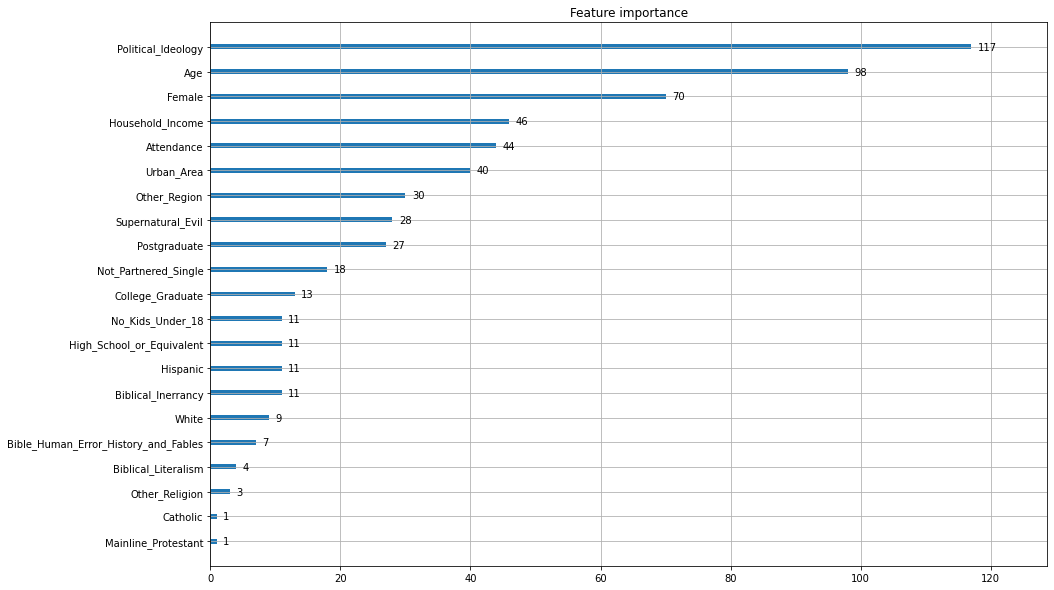

In [133]:
lgb.plot_importance(lgbmc, figsize=(15, 10), xlabel=None, ylabel=None);

* From the plot, we see that the predictor that has the most important role in the seperations is "Political_Ideology". After that, we see that "Age" and "Female" are important predictors too and differentiate from the others. "Supernatural_Evil" on the other hand doesn't seem to have a big strength.

(For the rest of the policies we follow the exactly same procedure. We use the same parameters for the GridSearchCV and we choose the best model according to the cross-validation score.) 

#### Ban on High-Capacity Ammo Clips

In [134]:
y = brs_data_dummies['Ban_on_High_Capacity_Ammo_Clips']
y

0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1567    1.0
1568    0.0
1569    1.0
1570    1.0
1571    0.0
Name: Ban_on_High_Capacity_Ammo_Clips, Length: 1572, dtype: float64

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##### Decision Tree Classifier

In [136]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2, min_samples_split=2 ,random_state=0)

scores = cross_val_score(decision_tree, X_train, y_train, cv=5)
scores.mean() 

0.7167183555715831

##### Bagging Classifier

In [137]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(random_state=0, max_depth=6, min_samples_leaf=4, min_samples_split=10), n_estimators=50, random_state=0)

scores = cross_val_score(bagging_tree, X_train, y_train, cv=5)
scores.mean()

0.7336783267219618

##### Random Forest Classifier

In [138]:
random_forest = RandomForestClassifier(bootstrap=True, max_depth=7, min_samples_leaf=2, min_samples_split=2, n_estimators=200, random_state=0)

scores = cross_val_score(random_forest, X_train, y_train, cv=5)
scores.mean() 

0.7472484673638657

##### Extremely Randomized Forest Classifier

In [139]:
extremely_rts = ExtraTreesClassifier(bootstrap=True, max_depth=8, min_samples_leaf=4, min_samples_split=10, n_estimators=100, random_state=0)

scores = cross_val_score(extremely_rts, X_train, y_train, cv=5)
scores.mean() 

0.7328344752975118

##### AdaBoost Classifier

In [140]:

ada_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=1, min_samples_leaf=2, min_samples_split=2), n_estimators=50, random_state=0)
scores = cross_val_score(ada_boost, X_train, y_train, cv=5)
scores.mean()

0.7175802380093762

##### XGBoost Classifier

In [141]:
xgbc = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss', gamma=0, learning_rate=0.01, max_depth=4, n_estimators=300, reg_alpha=0, random_state=0)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
scores.mean()

0.7370934006491165

##### LightGBM Classifier

In [142]:
lgbmc = lgb.LGBMClassifier(learning_rate=0.05, max_depth=3, min_child_weight=10.0, num_leaves=8, reg_alpha=0.05, reg_lambda=0.05, random_state=0)

scores = cross_val_score(lgbmc, X_train, y_train, cv=5)
scores.mean() 

0.7319870176703931

##### Best Model

* For this policy the best model is the Random Forest Classifier with score: 73.2%.
* We predict the test set to get the final accuracy of our model. 

In [143]:
random_forest.fit(X_train,y_train)
y_pred = random_forest.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.7099236641221374

* We see that the model achieved accuracy: 71%.
* We also plot the classification report and the confusion matrix.

In [144]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.29      0.39       123
         1.0       0.74      0.90      0.81       270

    accuracy                           0.71       393
   macro avg       0.65      0.60      0.60       393
weighted avg       0.68      0.71      0.68       393



In [145]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 36,  87],
       [ 27, 243]], dtype=int64)

* We notice that again the predictions for the voters in favor of the ban are more accurate (f1-score: 0.81). On the other hand, the predictions against, lack in accuracy and the model again tends to predict more the class with value 1.

##### Feature Importances

* Lastly, we plot the feature importances to see which predictors make a strong showing in the model.

In [146]:
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

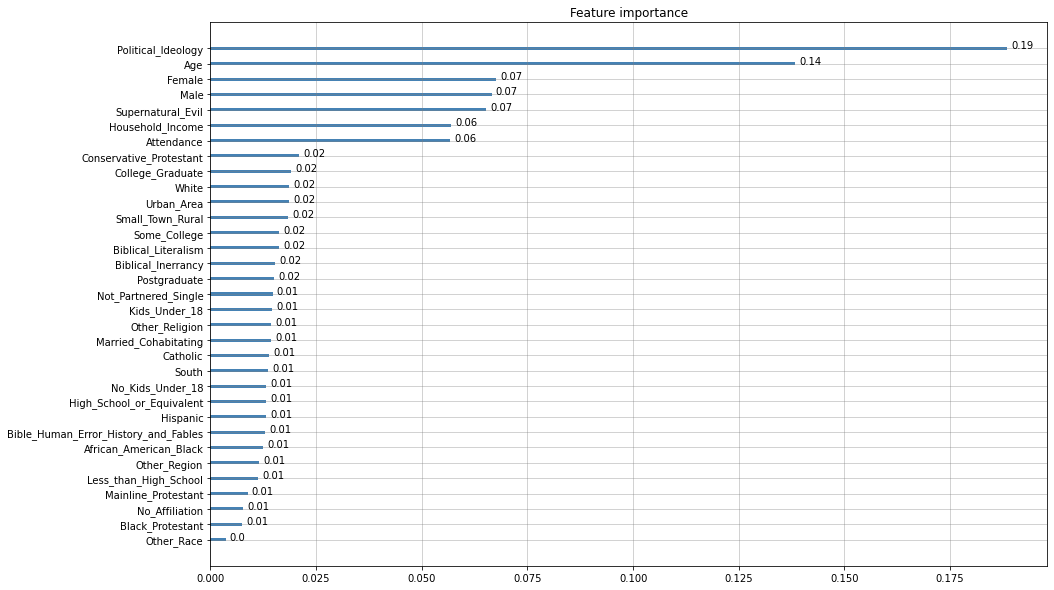

In [147]:
plt.figure(figsize=(15, 10))
plt.title('Feature importance')

plt.barh(list(X.columns[indices][::-1]), list(importances[indices][::-1]),
        color='steelblue', height=0.2)
        
plt.grid(b = True, color ='grey',
        linestyle ='-', linewidth = 0.5,
        alpha = 0.7)
        
for i, v in enumerate(list(importances[indices][::-1])):
    plt.text(v+ 0.001, i , str(round(v,2)), color='black')

* From the plot, we see that, again, the predictor that has the most important role in the seperations is "Political_Ideology" and one more time the predictors that follow are "Age" and "Female". However, this time "Supernatural_Evil" is stronger.

#### Banning Civilian Handguns

In [148]:
y = brs_data_dummies['Banning_Civilian_Handguns']
y

0       0.0
1       0.0
2       0.0
3       1.0
4       1.0
       ... 
1567    1.0
1568    1.0
1569    1.0
1570    1.0
1571    1.0
Name: Banning_Civilian_Handguns, Length: 1572, dtype: float64

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##### Decision Tree Classifier

In [150]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=1, min_samples_split=5, random_state=0)

scores = cross_val_score(decision_tree, X_train, y_train, cv=5)
scores.mean() 

0.7057050126217093

##### Bagging Classifier

In [151]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(random_state=0, max_depth=9, min_samples_leaf=2, min_samples_split=5), n_estimators=50, random_state=0)

scores = cross_val_score(bagging_tree, X_train, y_train, cv=5)
scores.mean()

0.7311575910566173

##### Random Forest Classifier

In [152]:
random_forest = RandomForestClassifier(bootstrap=False, max_depth=9, min_samples_leaf=2, min_samples_split=2, n_estimators=200, random_state=0)

scores = cross_val_score(random_forest, X_train, y_train, cv=5)
scores.mean() 

0.7328344752975118

##### Extremely Randomized Forest Classifier

In [153]:
extremely_rts = ExtraTreesClassifier(bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=150, random_state=0)

scores = cross_val_score(extremely_rts, X_train, y_train, cv=5)
scores.mean() 

0.7226361341507392

##### AdaBoost Classifier

In [154]:
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_leaf=1, min_samples_split=2), n_estimators=100, random_state=0)

scores = cross_val_score(ada_boost, X_train, y_train, cv=5)
scores.mean()

0.7235016227912009

##### XGBoost Classifier

In [155]:
xgbc = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss', gamma=1.5,learning_rate=0.1, max_depth=2, n_estimators=50, reg_alpha=1, random_state=0)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
scores.mean()

0.7336999639379733

##### LightGBM Classifier

In [156]:
lgbmc = lgb.LGBMClassifier(learning_rate=0.1, max_depth=3, min_child_weight=0.01, num_leaves=5, reg_alpha=0, reg_lambda=1, random_state=0)

scores = cross_val_score(lgbmc, X_train, y_train, cv=5)
scores.mean() 

0.7362387306166606

##### Best Model

* For this policy the best model is the LigthGBM Classifier with score: 73.6%.
* We predict the test set to get the final accuracy of our model.

In [157]:
lgbmc.fit(X_train,y_train)
y_pred = lgbmc.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.7201017811704835

* We see that the model achieved accuracy: 72%.
* We also plot the classification report and the confusion matrix.

In [158]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.88      0.82       284
         1.0       0.49      0.29      0.37       109

    accuracy                           0.72       393
   macro avg       0.63      0.59      0.59       393
weighted avg       0.69      0.72      0.69       393



In [159]:
metrics.confusion_matrix(y_test, y_pred)

array([[251,  33],
       [ 77,  32]], dtype=int64)

* We notice a similar pattern with the previous policies. The model achieved to predict, better, the voters against the policy (f1-score: 0.82) but couldn't predict accurately the voters in favor.

##### Feature Importances

* Lastly, we plot the feature importances to see which predictors make a strong showing in the model.

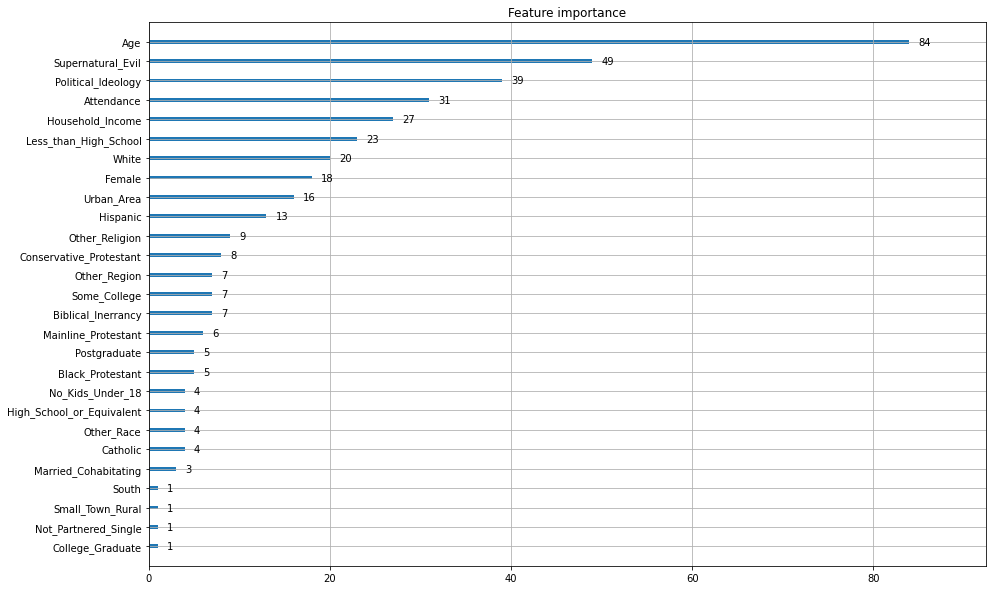

In [160]:
lgb.plot_importance(lgbmc, figsize=(15, 10), xlabel=None, ylabel=None);

* From the plot, we see that the predictor that has the most important role in the seperations is "Age". After that, we see that "Supernatural_Evil" , this time, is the second strongest predictor and plays an important role. Next,"Political_Ideology" and "Attendance" follow, with less importance.

#### Support for Concealed Carry Laws

In [161]:
y = brs_data_dummies['Support_for_Concealed_Carry_Laws']
y

0       1.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
1567    0.0
1568    0.0
1569    0.0
1570    0.0
1571    0.0
Name: Support_for_Concealed_Carry_Laws, Length: 1572, dtype: float64

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##### Decision Tree Classifier

In [163]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=1, min_samples_split=10 ,random_state=0)

scores = cross_val_score(decision_tree, X_train, y_train, cv=5)
scores.mean() 

0.6387342228633248

##### Bagging Classifier

In [164]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(random_state=0, max_depth=9, min_samples_leaf=2, min_samples_split=10), n_estimators=150, random_state=0)

scores = cross_val_score(bagging_tree, X_train, y_train, cv=5)
scores.mean()

0.6718067075369636

##### Random Forest Classifier

In [165]:
random_forest = RandomForestClassifier(bootstrap=True, max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=50, random_state=0)

scores = cross_val_score(random_forest, X_train, y_train, cv=5)
scores.mean()

0.6768553912729895

##### Extremely Randomized Forest Classifier

In [166]:
extremely_rts = ExtraTreesClassifier(bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=0)

scores = cross_val_score(extremely_rts, X_train, y_train, cv=5)
scores.mean() 

0.6632780382257483

##### AdaBoost Classifier

In [167]:
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=1, min_samples_leaf=3, min_samples_split=2), n_estimators=50, random_state=0)

scores = cross_val_score(ada_boost, X_train, y_train, cv=5)
scores.mean() 

0.6530941218896503

##### XGBoost Classifier

In [168]:
xgbc = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss', gamma=1.5,learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=1, random_state=0)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
scores.mean()

0.6684060584204833

##### LightGBM Classifier

In [169]:
lgbmc = lgb.LGBMClassifier(learning_rate=0.2, max_depth=2, min_child_weight=10.0, num_leaves=5, reg_alpha=0.01, reg_lambda=0, random_state=0)

scores = cross_val_score(lgbmc, X_train, y_train, cv=5)
scores.mean() 

0.6658528669311214

##### Best Model

* For this policy the best model is the Random Forest Classifier with score: 67.7%.
* We predict the test set to get the final accuracy of our model.

In [170]:
random_forest.fit(X_train,y_train)
y_pred = random_forest.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.6641221374045801

* We see that the model achieved accuracy: 66%.
* We also plot the classification report and the confusion matrix.

In [171]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.53      0.58       175
         1.0       0.67      0.78      0.72       218

    accuracy                           0.66       393
   macro avg       0.66      0.65      0.65       393
weighted avg       0.66      0.66      0.66       393



In [172]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 92,  83],
       [ 49, 169]], dtype=int64)

* We notice that in this policy things are better. The model achieved to predict, the voters in favor of the policy with a moderate accuracy (f1-score: 0.72), but the predictions for the voters against isn't that bad as in the previous policies.

##### Feature Importances

* Lastly, we plot the feature importances to see which predictors make a strong showing in the model.

In [173]:
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

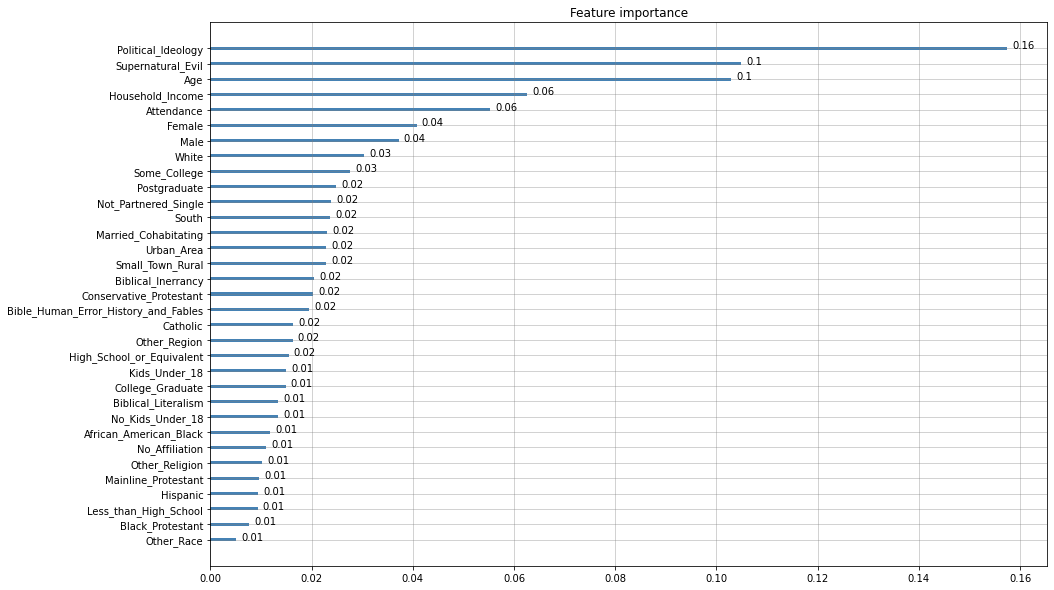

In [174]:
plt.figure(figsize=(15, 10))
plt.title('Feature importance')

plt.barh(list(X.columns[indices][::-1]), list(importances[indices][::-1]),
        color='steelblue', height=0.2)
        
plt.grid(b = True, color ='grey',
        linestyle ='-', linewidth = 0.5,
        alpha = 0.7)
        
for i, v in enumerate(list(importances[indices][::-1])):
    plt.text(v+ 0.001, i , str(round(v,2)), color='black')

* From the plot, we see that "Political_Ideology" again dominates in the importance. Also, "Superantural_Evil" stays second in the scale together with "Age".

#### More Armed Security at Schools

In [175]:
y = brs_data_dummies['More_Armed_Security_at_Schools']
y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1567    1.0
1568    0.0
1569    0.0
1570    0.0
1571    1.0
Name: More_Armed_Security_at_Schools, Length: 1572, dtype: float64

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##### Decision Tree Classifier

In [177]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=1, min_samples_split=2 ,random_state=0)

scores = cross_val_score(decision_tree, X_train, y_train, cv=5)
scores.mean() 

0.6869960331770646

##### Bagging Classifier

In [178]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_leaf=2, min_samples_split=10), n_estimators=50, random_state=0)

scores = cross_val_score(bagging_tree, X_train, y_train, cv=5)
scores.mean()

0.687854309412189

##### Random Forest Classifier

In [179]:
random_forest = RandomForestClassifier(bootstrap=False, max_depth=7, min_samples_leaf=3, min_samples_split=10, n_estimators=150, random_state=0)

scores = cross_val_score(random_forest, X_train, y_train, cv=5)
scores.mean() 

0.7039596105301118

##### Extremely Randomized Forest Classifier

In [180]:
extremely_rts = ExtraTreesClassifier(bootstrap=True, max_depth=9, min_samples_leaf=4, min_samples_split=10, n_estimators=100, random_state=0)

scores = cross_val_score(extremely_rts, X_train, y_train, cv=5)
scores.mean() 

0.6937937252073566

##### AdaBoost Classifier

In [181]:
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=1, min_samples_leaf=1, min_samples_split=2), n_estimators=50, random_state=0)

scores = cross_val_score(ada_boost, X_train, y_train, cv=5)
scores.mean() 

0.6666209880995311

##### XGBoost Classifier

In [182]:
xgbc = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss', gamma=1.5, learning_rate=0.01, max_depth=3, n_estimators=300, reg_alpha=0, random_state=0)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
scores.mean()

0.6929174179588893

##### LightGBM Classifier

In [183]:
lgbmc = lgb.LGBMClassifier(learning_rate=0.1, max_depth=2, min_child_weight=0.01, num_leaves=5, reg_alpha=0, reg_lambda=0.05, random_state=0)

scores = cross_val_score(lgbmc, X_train, y_train, cv=5)
scores.mean() 

0.692921024161558

##### Best Model

* For this policy the best model is the Random Forest Classifier with score: 70.4%.
* We predict the test set to get the final accuracy of our model.

In [184]:
random_forest.fit(X_train,y_train)
y_pred = random_forest.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.6793893129770993

* We see that the model achieved accuracy: 68%.
* We also plot the classification report and the confusion matrix.

In [185]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.34      0.44       143
         1.0       0.70      0.87      0.78       250

    accuracy                           0.68       393
   macro avg       0.65      0.61      0.61       393
weighted avg       0.66      0.68      0.65       393



In [186]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 49,  94],
       [ 32, 218]], dtype=int64)

* We notice that the model achieved to predict, better, the voters in favor of the policy (f1-score: 0.78) but couldn't predict so accurately the voters against.

##### Feature Importances

* Lastly, we plot the feature importances to see which predictors make a strong showing in the model.

In [187]:
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

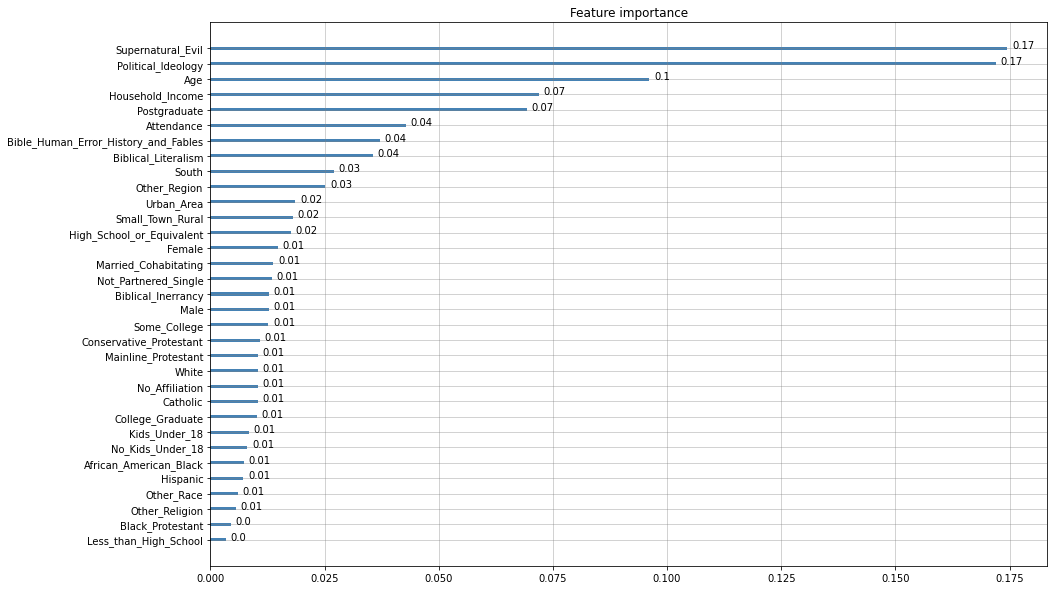

In [188]:
plt.figure(figsize=(15, 10))
plt.title('Feature importance')

plt.barh(list(X.columns[indices][::-1]), list(importances[indices][::-1]),
        color='steelblue', height=0.2)
        
plt.grid(b = True, color ='grey',
        linestyle ='-', linewidth = 0.5,
        alpha = 0.7)
        
for i, v in enumerate(list(importances[indices][::-1])):
    plt.text(v+ 0.001, i , str(round(v,2)), color='black')

* From the plot, we see that this time the predictor that has the most important role in the seperations is "Supernatural_Evil". After that, we see that "Political_Ideology" and "Age" are important predictors too and differentiate from the others. Moreover, as expected from the regressions, "Postgraduate" and "Household_Income" play an important role in this policy.

#### More Teachers Faculty having Guns

In [189]:
y = brs_data_dummies['More_Teachers_Faculty_having_Guns']
y

0       1.0
1       1.0
2       0.0
3       0.0
4       1.0
       ... 
1567    0.0
1568    0.0
1569    0.0
1570    0.0
1571    0.0
Name: More_Teachers_Faculty_having_Guns, Length: 1572, dtype: float64

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##### Decision Tree Classifier

In [191]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=1, min_samples_split=10, random_state=0)

scores = cross_val_score(decision_tree, X_train, y_train, cv=5)
scores.mean() 

0.7150198341146773

##### Bagging Classifier

In [192]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_leaf=1, min_samples_split=2), n_estimators=200, random_state=0)

scores = cross_val_score(bagging_tree, X_train, y_train, cv=5)
scores.mean()

0.7218139199423008

##### Random Forest Classifier

In [193]:
random_forest = RandomForestClassifier(bootstrap=False, max_depth=6, min_samples_leaf=3, min_samples_split=2, n_estimators=100, random_state=0)

scores = cross_val_score(random_forest, X_train, y_train, cv=5)
scores.mean() 

0.7209520375045078

##### Extremely Randomized Forest Classifier

In [194]:
extremely_rts = ExtraTreesClassifier(bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=150, random_state=0)

scores = cross_val_score(extremely_rts, X_train, y_train, cv=5)
scores.mean() 

0.7184132708258204

##### AdaBoost Classifier

In [195]:
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=1, min_samples_leaf=3, min_samples_split=2), n_estimators=150, random_state=0)

scores = cross_val_score(ada_boost, X_train, y_train, cv=5)
scores.mean()

0.7116336098088714

##### XGBoost Classifier

In [196]:
xgbc = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss', gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=1, random_state=0)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
scores.mean()

0.7252109628561125

##### LightGBM Classifier

In [197]:
lgbmc = lgb.LGBMClassifier(learning_rate=0.1, max_depth=2, min_child_weight=0.01, num_leaves=5, reg_alpha=0, reg_lambda=0, random_state=0)

scores = cross_val_score(lgbmc, X_train, y_train, cv=5)
scores.mean() 

0.7218067075369635

##### Best Model

* For this policy the best model is the XGBoost Classifier with score: 72.5%.
* We predict the test set to get the final accuracy of our model 

In [198]:
xgbc.fit(X_train,y_train)
y_pred = xgbc.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.7175572519083969

* We see that the model achieved accuracy: 72%.
* We also plot the classification report and the confusion matrix.

In [199]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.92      0.82       276
         1.0       0.56      0.25      0.34       117

    accuracy                           0.72       393
   macro avg       0.65      0.58      0.58       393
weighted avg       0.69      0.72      0.68       393



In [200]:
metrics.confusion_matrix(y_test, y_pred)

array([[253,  23],
       [ 88,  29]], dtype=int64)

* We notice again a very similar pattern with the previous policies. The model achieved to predict, better, the voters against the policy.

##### Feature Importances

* Lastly, we plot the feature importances to see which predictors make a strong showing in the model.

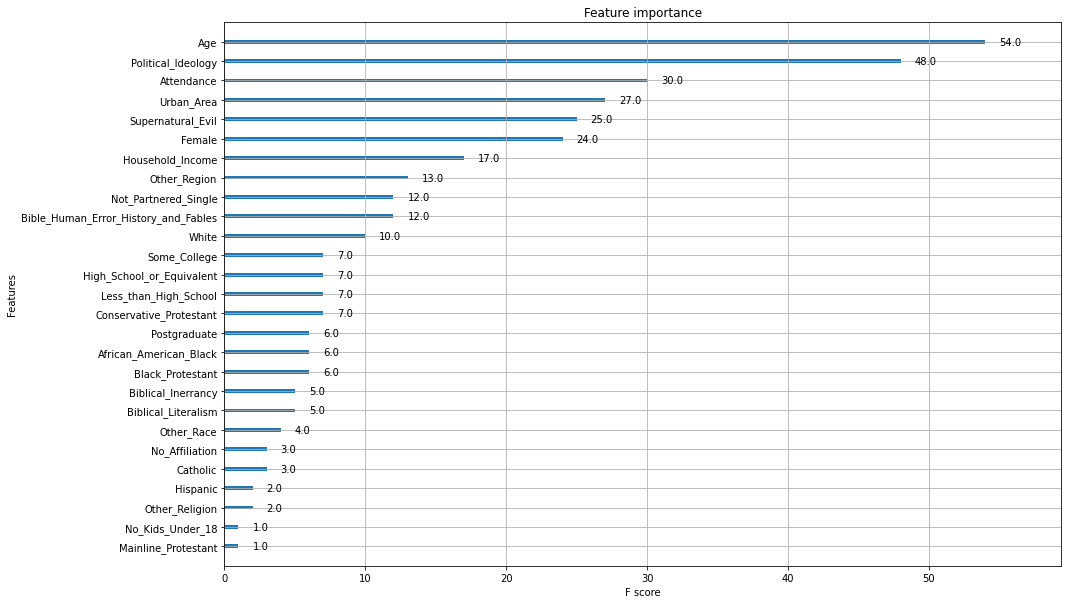

In [201]:
fig = plt.figure(figsize=(15, 10))
xgbc.get_booster().feature_names = list(X.columns)
xgb.plot_importance(xgbc, ax = fig.gca());

* From the plot, we seet that the most important predictor is "Age". Beyond that, we see "Political_Ideology" and "Attendance" being important too. Also, "Superantural_Evil" shows a moderate strength, as well.

#### More Gun Safety Programs

In [202]:
y = brs_data_dummies['More_Gun_Safety_Programs']
y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1567    1.0
1568    1.0
1569    1.0
1570    1.0
1571    1.0
Name: More_Gun_Safety_Programs, Length: 1572, dtype: float64

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##### Decision Tree Classifier

In [204]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=1, min_samples_leaf=1, min_samples_split=2, random_state=0)

scores = cross_val_score(decision_tree, X_train, y_train, cv=5)
scores.mean() 

0.9168806346916696

##### Bagging Classifier

In [205]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(random_state=0, max_depth=8, min_samples_leaf=1, min_samples_split=5), n_estimators=100, random_state=0)

scores = cross_val_score(bagging_tree, X_train, y_train, cv=5)
scores.mean()

0.9185791561485755

##### Random Forest Classifier

In [206]:
random_forest = RandomForestClassifier(bootstrap=True, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0)

scores = cross_val_score(random_forest, X_train, y_train, cv=5)
scores.mean() 

0.9168806346916696

##### Extremely Randomized Forest Classifier

In [207]:
extremely_rts = ExtraTreesClassifier(bootstrap=True, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0)

scores = cross_val_score(extremely_rts, X_train, y_train, cv=5)
scores.mean() 

0.9168806346916696

##### AdaBoost Classifier

In [208]:
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_leaf=1, min_samples_split=2), n_estimators=200, random_state=0)

scores = cross_val_score(ada_boost, X_train, y_train, cv=5)
scores.mean()

0.9083916336098088

##### XGBoost Classifier

In [209]:
xgbc = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss', gamma=0,learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=0, random_state=0)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
scores.mean()

0.9168806346916696

##### LightGBM Classifier

In [210]:
lgbmc = lgb.LGBMClassifier(learning_rate=0.05, max_depth=1, min_child_weight=0.01, num_leaves=5, reg_alpha=0, reg_lambda=0, random_state=0)

scores = cross_val_score(lgbmc, X_train, y_train, cv=5)
scores.mean() 

0.9168806346916696

##### Best Model

* For this policy that best model is the Bagging Classifier with score: 91.8%.
* We predict the test set to get the final accuracy of our model.

In [211]:
bagging_tree.fit(X_train,y_train)
y_pred = bagging_tree.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9567430025445293

* We see that the model achieved accuracy: 96%.
* We also plot the classification report and the confusion matrix.

In [212]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        17
         1.0       0.96      1.00      0.98       376

    accuracy                           0.96       393
   macro avg       0.48      0.50      0.49       393
weighted avg       0.92      0.96      0.94       393



C:\Users\Nikolas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nikolas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nikolas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [213]:
metrics.confusion_matrix(y_test, y_pred)

array([[  0,  17],
       [  0, 376]], dtype=int64)

* We notice that the model predicted only in favor of the policy. This could be because previously in the regressions we saw that the predicotrs for this policy were insignificant and didn't have a strong predicting ability. An other reason is that since there are very limited answers with value 0 and as a result the data is imbalanced, the tree can't learn efficiently.

##### Feature Importances

* Lastly, we plot the feature importances to see which predictors make a strong showing in the model.

In [214]:
importances = np.mean([
    tree.feature_importances_ for tree in bagging_tree.estimators_
], axis=0)

std = np.std([tree.feature_importances_ for tree in bagging_tree.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

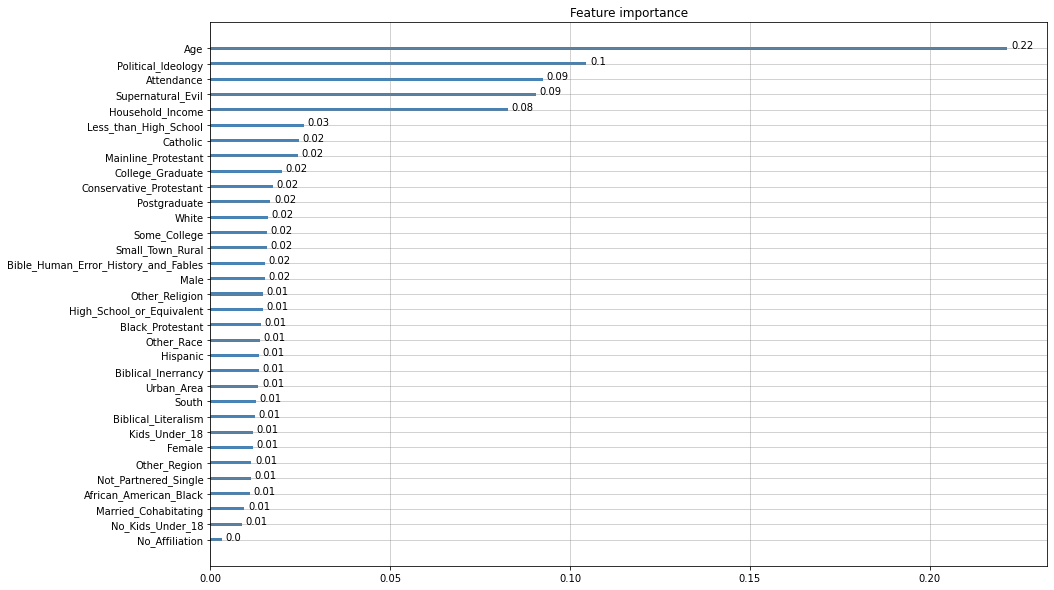

In [215]:
plt.figure(figsize=(15, 10))
plt.title('Feature importance')

plt.barh(list(X.columns[indices][::-1]), list(importances[indices][::-1]),
        color='steelblue', height=0.2)
        
plt.grid(b = True, color ='grey',
        linestyle ='-', linewidth = 0.5,
        alpha = 0.7)
        
for i, v in enumerate(list(importances[indices][::-1])):
    plt.text(v+ 0.001, i , str(round(v,2)), color='black')

* Despite the inability of the model to predict accurately, we see as important predictors "Age" and then "Political_Ideology", which appear in most of the policies.

#### Expanded Mental Health Screening

In [216]:
y = brs_data_dummies['Expanded_Mental_Health_Screening']
y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1567    1.0
1568    1.0
1569    1.0
1570    1.0
1571    1.0
Name: Expanded_Mental_Health_Screening, Length: 1572, dtype: float64

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

##### Decision Tree Classifier

In [218]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=1, min_samples_leaf=1, min_samples_split=2 ,random_state=0)

scores = cross_val_score(decision_tree, X_train, y_train, cv=5)
scores.mean() 

0.9100937612693834

##### Bagging Classifier

In [219]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(random_state=0, max_depth=4, min_samples_leaf=2, min_samples_split=10), n_estimators=50, random_state=0)

scores = cross_val_score(bagging_tree, X_train, y_train, cv=5)
scores.mean()

0.910941218896502

##### Random Forest Classifier

In [220]:
random_forest = RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=50, random_state=0)

scores = cross_val_score(random_forest, X_train, y_train, cv=5)
scores.mean()

0.9117886765236207

##### Extremely Randomized Forest Classifier

In [221]:
extremely_rts = ExtraTreesClassifier(bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0)

scores = cross_val_score(extremely_rts, X_train, y_train, cv=5)
scores.mean() 

0.9117886765236207

##### AdaBoost Classifier

In [222]:
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=1, min_samples_leaf=1, min_samples_split=2), n_estimators=50, random_state=0)

scores = cross_val_score(ada_boost, X_train, y_train, cv=5)
scores.mean() 

0.9033177064551028

##### XGBoost Classifier

In [223]:
xgbc = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss', gamma=0,learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=0.001, random_state=0)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
scores.mean()

0.910941218896502

##### LightGBM Classifier

In [224]:
lgbmc = lgb.LGBMClassifier(learning_rate=0.1, max_depth=4, min_child_weight=10.0, num_leaves=5, reg_alpha=0.05, reg_lambda=1, random_state=0)

scores = cross_val_score(lgbmc, X_train, y_train, cv=5)
scores.mean() 

0.9134835917778579

##### Best Model

* For this policy that best model is LigthGBM Classifier with score: 91.3%.
* We predict the test_set to get the final accuracy of our model 

In [225]:
lgbmc.fit(X_train,y_train)
y_pred = lgbmc.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9083969465648855

* We see that the model achieved accuracy: 91%.
* We also plot the classification report and the confusion matrix.

In [226]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        36
         1.0       0.91      1.00      0.95       357

    accuracy                           0.91       393
   macro avg       0.45      0.50      0.48       393
weighted avg       0.83      0.91      0.86       393



C:\Users\Nikolas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nikolas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nikolas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

* We notice that the same thing that happened with the previous policy happens here too. The policy has very limited significant predictors and the data is imbalanced. 

##### Feature Importances

* Lastly, we plot the feature importances to see which predictors make a strong showing in the model.

In [227]:
metrics.confusion_matrix(y_test, y_pred)

array([[  0,  36],
       [  0, 357]], dtype=int64)

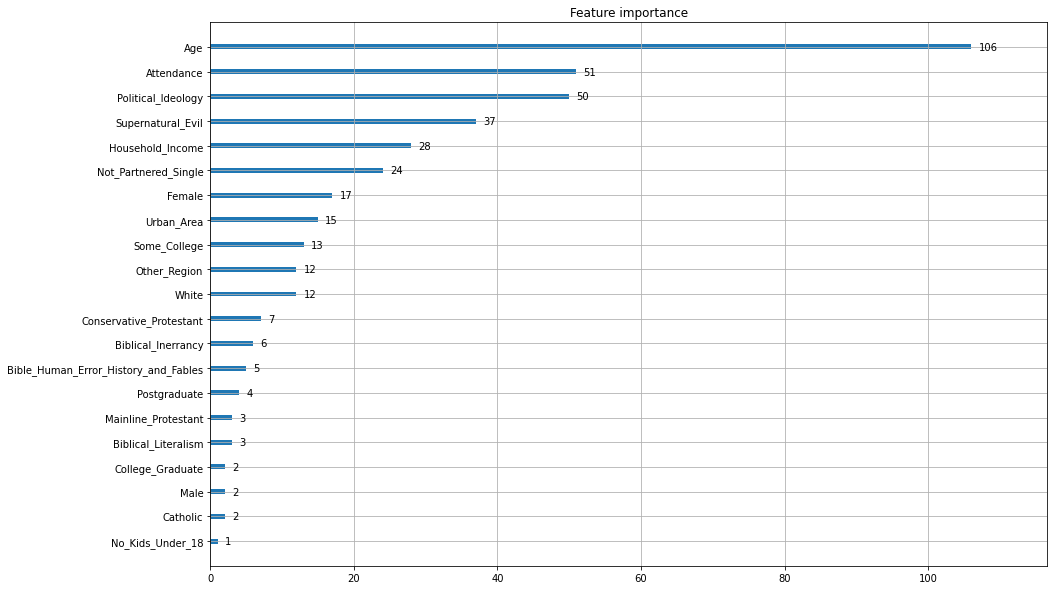

In [228]:
lgb.plot_importance(lgbmc, figsize=(15, 10), xlabel=None, ylabel=None);

* Similar to the previous policy the model is not able to carry out accurate predictions. Although, again, the important predictors ("Age", "Attendance" and "Political_Ideology") are variables that have be seen, repeatedly, as important.

#### Discussion

After reviewing the feature importances, we see that most of the variables that were important in the logistic and the linear regressions, seem to be important in the predicting models too. "Political_Ideology" and "Age" which were both important and statistically significant predictors make a strong showing in the models. Also, "Female", which was one of the most strong predictors, has been high in the importance scales, as well. Lastly, regarding our focal variable, "Supernatural_Evil", we notice that it's almost always one of the most important features in the models and plays an important role in the prediction of the policies, for sure. 